# Entrainement des modèles

Ce notebook regroupe le travail d'entrainement et de sélection de modèles entraînés sur les données de consommation électrique des bâtiments de la ville de Seattle.

## Contexte

La ville de Seattle souhaite atteindre la neutralité carbonne en 2050. Afin d'étudier les modalités de mise en oeuvre, la municipalité a mis à disposition, via [Kaggle](https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking), les relevés de consommation d'énergie et d'émission des bâtiments en 2015 et 2016.

L'objectif est d'entraîner une solution de machine learning afin de prédire les émissions de CO2 ( variable GHGEmissions(MetricTonsCO2e))  et la consommation totale d'énergie (variable SiteEnergyUseWN(kBtu)) de bâtiments qui n'ont pas encore fait l'objet de mesures. Nottons que pour la conssommation d'énergie titale, nous privilégions l'utilisation de l'indicateur normalisé par la météo.

Lors des travaux il est également demandé d'évaluer l'intérêt de l'indicateur [ENERGY STAR Score](https://www.energystar.gov/buildings/benchmark/analyze_benchmarking_results) afin de réaliser les prédictions.

## Importation des données

Les données ont déjà été prétraitées dans le notebook Pélec_01_notebookanalyse.ipynb et stockées dans les fichiers data_2015.csv et data_2016.csv. 
Comme vu dans le notebook précédents, les deux fichier comportent un nombre très important d'observation ayant fait l'objet de relevés sur les deux années. Les distributions des variables à prédire évoluent peu significativement entre les deux années. De ce fait nous réaliseront l'entrainement des modèles  et l'évaueation ddes performances sur l'année 2015. Une fois les meilleurs modèles sélectionnés nous réaliserons des entrainements avec les même hyperparamètres et évaluation de performances pour l'année 2016.

Nous commençons par importer les données sur 2015

In [240]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")
%matplotlib inline

data_2015 = pd.read_csv("data_2015.csv", index_col="OSEBuildingID")
display(data_2015.head())
print(f"Nombre d'observations {data_2015.shape[0]}")
print(f"Nombre de variables {data_2015.shape[1]}")

,YearBuilt,PropertyGFATotal,GFA_by_floor,more_one_building,PropertyUseTypes,PrimaryPropertyType,Multifamily Housing_prop,Non-Refrigerated Warehouse_prop,Worship Facility_prop,Self-Storage Facility_prop,...,Laboratory_prop,Restaurant_prop,Automobile Dealership_prop,Office_prop,Electricity(kBtu)_prop,NaturalGas(kBtu)_prop,SteamUse(kBtu)_prop,ENERGYSTARScore,SiteEnergyUseWN(kBtu),GHGEmissions(MetricTonsCO2e)
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,
1,1927,88434,7370.0,0,1,Hotel,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,51.94,17.93,28.50,65.0,7097539.0,249.43
2,1996,103566,9415.0,0,3,Hotel,0.0,0.0,0.0,0.0,...,0.0,4.46,0.0,0.0,44.55,50.75,0.00,51.0,8765788.0,263.51
3,1969,961990,23463.0,0,3,Hotel,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,65.91,4.91,26.04,18.0,75506272.0,2061.48
9,1999,97288,48644.0,0,1,Other,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,55.74,36.65,0.00,99.0,13045258.0,304.62
10,1926,83008,7546.0,0,1,Hotel,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,41.37,55.16,0.00,25.0,6477493.0,208.46


Nombre d'observations 2933
Nombre de variables 27


## Séparation des données

Le nombre d'observations étant relativment restraint nous décidons conserver 80% des données pour l'entraînement. Le partitionnement est réalisé avec une stratification sur la variable PropertyGFATotal que nous discrétisons au préalable sur 6 classes.

In [241]:
from sklearn.preprocessing import KBinsDiscretizer
kbins = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='uniform')
data_2015["discretized_GFATotal"] = kbins.fit_transform(data_2015["PropertyGFATotal"].values.reshape(-1,1))
reordered_cols = ['YearBuilt', 
                 'PropertyGFATotal', 
                 'discretized_GFATotal', 
                 'GFA_by_floor', 
                 'more_one_building',
                 'PropertyUseTypes', 
                 'Multifamily Housing_prop',
                 'Non-Refrigerated Warehouse_prop',
                 'Worship Facility_prop',
                 'Self-Storage Facility_prop', 
                 'Distribution Center_prop',
                 'K-12 School_prop', 
                 'Supermarket/Grocery Store_prop', 
                 'Hotel_prop',
                 'Other_prop', 
                 'Parking_prop',
                 'Hospital (General Medical & Surgical)_prop', 
                 'Laboratory_prop',
                 'Restaurant_prop', 
                 'Automobile Dealership_prop', 
                 'Office_prop',
                 'Electricity(kBtu)_prop', 
                 'NaturalGas(kBtu)_prop',
                 'SteamUse(kBtu)_prop', 
                 'ENERGYSTARScore', 
                 'SiteEnergyUseWN(kBtu)',
                 'GHGEmissions(MetricTonsCO2e)']
data_2015 = data_2015[reordered_cols]

Nous pouvons à présent procéder à la partition puis supprimer la colonne de la variable discrétisée.

In [242]:
from sklearn.model_selection import train_test_split 

X_energy = data_2015.iloc[:,:-2].copy()
X_co2 = data_2015.iloc[:,:-2].copy()
y_energy = data_2015["SiteEnergyUseWN(kBtu)"].copy()
y_co2 = data_2015["GHGEmissions(MetricTonsCO2e)"].copy()

X_energy_train, X_energy_test, y_energy_train, y_energy_test = train_test_split(X_energy,y_energy, test_size=0.2, stratify=X_energy["discretized_GFATotal"] , random_state=42)
X_co2_train, X_co2_test, y_co2_train, y_co2_test = train_test_split(X_co2,y_co2, test_size=0.2, stratify=X_co2["discretized_GFATotal"] , random_state=42)

print(f"Nombre d'observations du jeu d'entraînement pour la prédicton de consommation d'énergie : {X_energy_train.shape[0]}")
print(f"Nombre d'observations du jeu d'entraînement pour la prédicton des émissions de CO2: {X_co2_train.shape[0]}")
print(f"Nombre d'observations du jeu de test pour la prédiction de consommation d'énergie: {X_energy_test.shape[0]}")
print(f"Nombre d'observations du jeu de test pour la prédiction des émissions de CO2 : {X_co2_test.shape[0]}")

data_2015.drop(columns="discretized_GFATotal", inplace=True)

Nombre d'observations du jeu d'entraînement pour la prédicton de consommation d'énergie : 2346
Nombre d'observations du jeu d'entraînement pour la prédicton des émissions de CO2: 2346
Nombre d'observations du jeu de test pour la prédiction de consommation d'énergie: 587
Nombre d'observations du jeu de test pour la prédiction des émissions de CO2 : 587


## Preprocessing

Observons l'échelle des distributions afin de déterminer les transformation de variables à effectuer

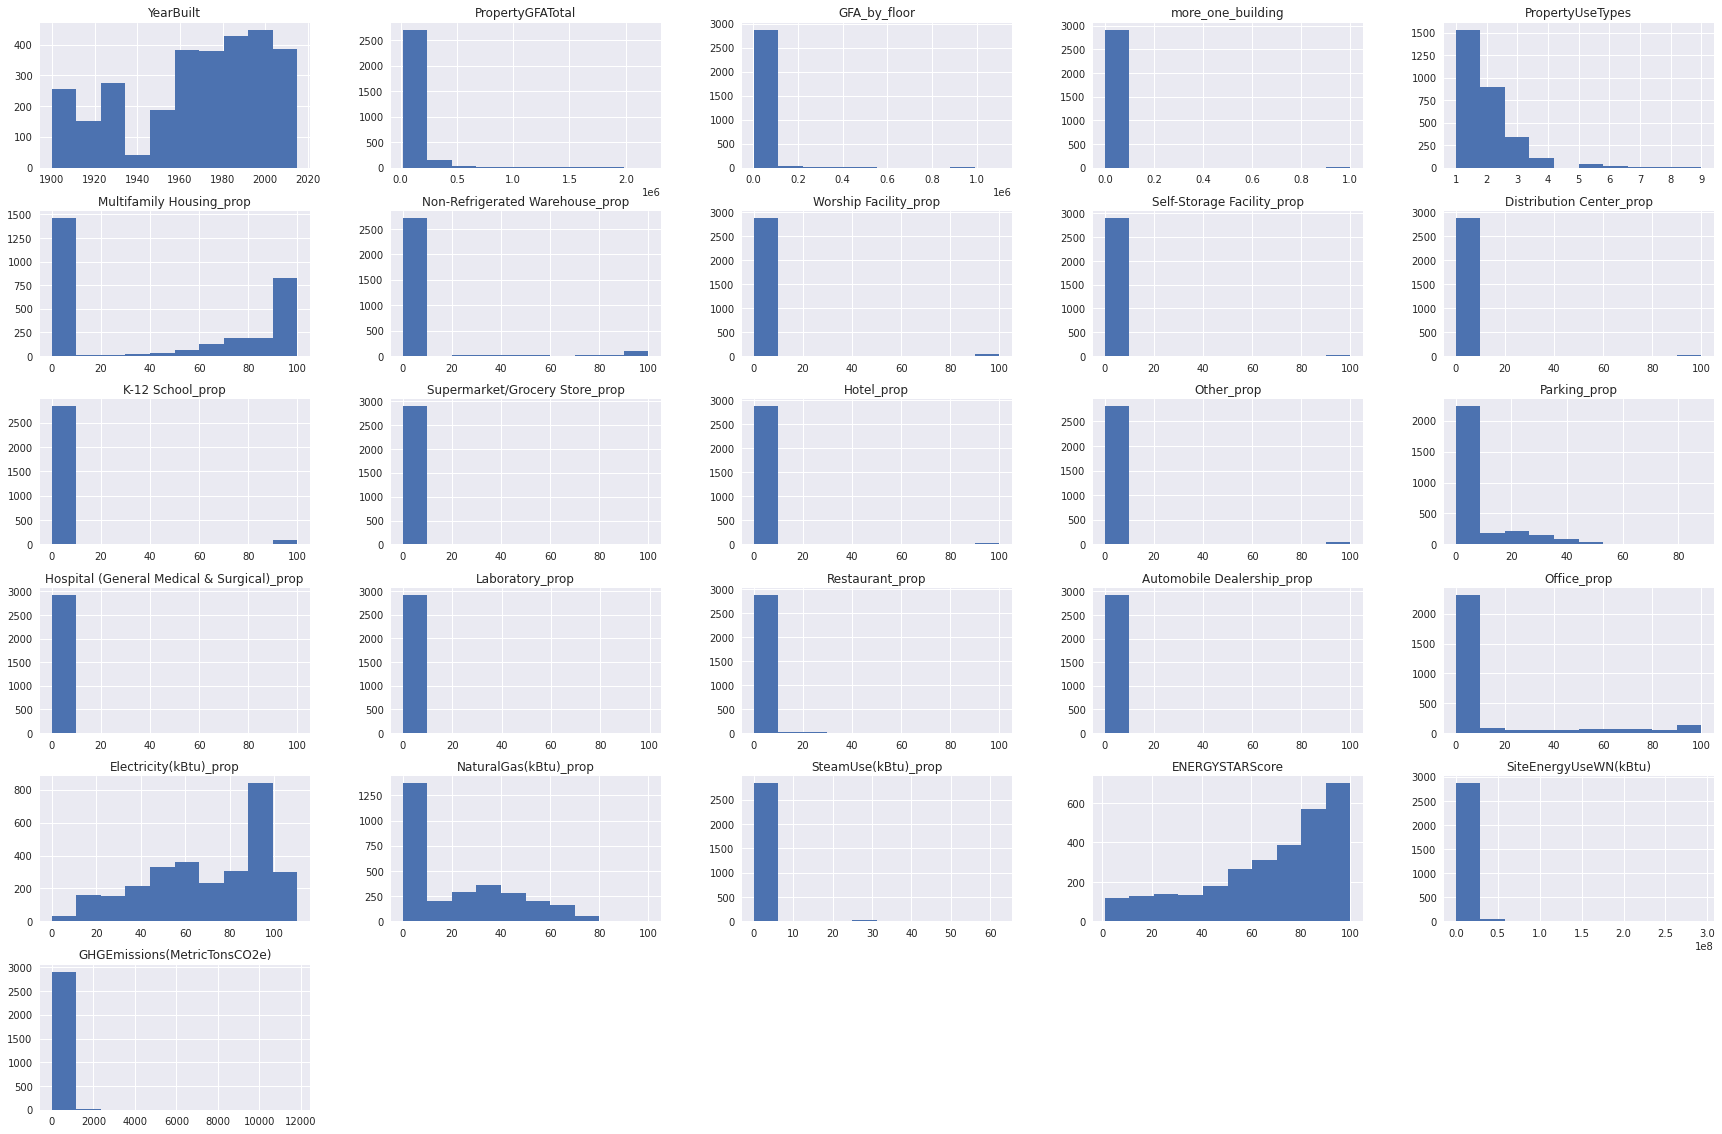

In [85]:
data_2015.hist(figsize=(30, 20))
plt.show()

Afin de réaliser le prépocessing nous allons réaliser les traitements suivant: 
- Aucun traitelment sur la variable more_one_building, il s'agit d'une variable binaire
- Sur les autre variables:
    - Nous utilisons d'abord un RobustScaler(), il s'agit d'un centrage avec une soustraction par la médiane au lieu de la moyenne puis d'une réduction sur l'inter-quartile au lieu de l'équart type
    - Nous utilisons ensuite une MinMaxScaler() pour ramener toutes les échelles entre 0 et 1
    
Dans les phases préliminaires nous avons aussi testé des transformations log, BoxCox et Yeao-Johson pour toutes les variables qui ont des distributions log-normale :
- PropertyGFATotal
- GFA_by_floor
- Les variables à préidire : SiteEnergyUseWN(kBtu) et "GHGEmissions(MetricTonsCO2e)"

Les résultats étaient moins bon et ne l'avons pas concervé.  Nous avons code le code commenté pour la transformation log afin de pouvoir refaire des test si besoin.

In [243]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer

no_transformation_cols = [
                          "more_one_building"
                        ]

to_scale_cols = [
                 "PropertyGFATotal",
                 "GFA_by_floor",
                 "PropertyUseTypes",
                 "YearBuilt",
                 "ENERGYSTARScore",
                 "Multifamily Housing_prop",
                 "Non-Refrigerated Warehouse_prop",
                 "Worship Facility_prop",
                 "Self-Storage Facility_prop",
                 "Distribution Center_prop",
                 "K-12 School_prop",
                 "Supermarket/Grocery Store_prop" ,
                 "Hotel_prop",
                 "Other_prop",
                 "Parking_prop",
                 "Hospital (General Medical & Surgical)_prop" ,
                 "Laboratory_prop",
                 "Restaurant_prop",
                 "Automobile Dealership_prop",
                 "Office_prop",
                 "SteamUse(kBtu)_prop",
                 "Electricity(kBtu)_prop",
                 "NaturalGas(kBtu)_prop", 
                ]

to_scale_and_log_cols = [
                       
                        ]


def preprocessing_data(X_train, X_test, no_transformation_cols, to_scale_cols, to_scale_and_log_cols):
    """
    Preprocess data in order to train machine learning models
    
    Args:
        X_train(DataFrame): Train set input variables to preprocess
        
        X_test(DataFrame): Test set input variables to preprocess 
        
        no_transformation_cols(list): List of variables that will not be transformed
        
        to_standardise_cols(list): List of variables to be standardised
        
        to_log_cols(list): List of variables to be log scaled
    
    Returns:
        X_train_preprocessed(DataFrame): Preprocessed train set 
        
        X_test_transformed(DataFRame): Preprocessed test set
    """

    X_train_no_transformation = pd.DataFrame(X_train.loc[:,no_transformation_cols], columns=no_transformation_cols)
    X_test_no_transformation = pd.DataFrame(X_test.loc[:,no_transformation_cols], columns=no_transformation_cols)
    
    
    scaler = Pipeline(steps=[
                              ('Robust', RobustScaler()),
                              ('MinMax', MinMaxScaler())
                             ]
                      )
    
    scaler.fit(X_train.loc[:,to_scale_cols])
    X_train_to_scale = pd.DataFrame(scaler.transform(X_train.loc[:,to_scale_cols]), columns=to_scale_cols, index=X_energy_train.index)
    X_test_to_scale =  pd.DataFrame(scaler.transform(X_test.loc[:,to_scale_cols]), columns=to_scale_cols, index=X_energy_test.index)
    
    #transformer = Pipeline(steps=[
                                  #('log', FunctionTransformer(func=np.log1p, inverse_func=np.expm1)),
                                  #('Robust', RobustScaler()),
                                  #('MinMax', MinMaxScaler())
                                 #]
                          #)
    
    #transformer.fit(X_train.loc[:,to_scale_and_log_cols])
    #X_train_to_scale_and_log = pd.DataFrame(transformer.transform(X_train.loc[:,to_scale_and_log_cols]), columns=to_scale_and_log_cols, index=X_energy_train.index)
    #X_test_to_scale_and_log =  pd.DataFrame(transformer.transform(X_test.loc[:,to_scale_and_log_cols]), columns=to_scale_and_log_cols, index=X_energy_test.index)
    

    X_train_transformed = pd.concat([X_train_no_transformation, X_train_to_scale] ,  axis=1)
    X_test_transformed = pd.concat([X_test_no_transformation, X_test_to_scale], axis=1)
    
    return X_train_transformed, X_test_transformed

X_energy_train_transformed , X_energy_test_transformed = preprocessing_data(X_energy_train, X_energy_test, no_transformation_cols, to_scale_cols, to_scale_and_log_cols)
X_co2_train_transformed, X_co2_test_transformed = preprocessing_data(X_co2_train, X_co2_test, no_transformation_cols, to_scale_cols, to_scale_and_log_cols)

X_energy_train_transformed_wo_estar = X_energy_train_transformed.drop(columns="ENERGYSTARScore")
X_energy_test_transformed_wo_estar = X_energy_test_transformed.drop(columns="ENERGYSTARScore")
X_co2_train_transformed_wo_estar = X_co2_train_transformed.drop(columns="ENERGYSTARScore")
X_co2_test_transformed_wo_estar = X_co2_test_transformed.drop(columns="ENERGYSTARScore")




print("Cinq premières lignes du jeu d'entraînement transformé pour la prédiction de la consommation d'énergie")
display(X_energy_train_transformed.head())
print("Cinq premières lignes du jeu de test transformé pour la transformation d'énergie")
display(X_energy_test_transformed.head())
print(f"Nombre d'observations du jeu d'entraînement pour la prédicton de consommation d'énergie : {X_energy_train_transformed.shape[0]}")
print(f"Nombre d'observations du jeu d'entraînement pour la prédicton des émissions de CO2: {X_co2_train_transformed.shape[0]}")
print(f"Nombre d'observations du jeu de test pour la prédiction de consommation d'énergie: {X_energy_test_transformed.shape[0]}")
print(f"Nombre d'observations du jeu de test pour la prédiction des émissions de CO2 : {X_co2_test_transformed.shape[0]}")

Cinq premières lignes du jeu d'entraînement transformé pour la prédiction de la consommation d'énergie


,more_one_building,PropertyGFATotal,GFA_by_floor,PropertyUseTypes,YearBuilt,ENERGYSTARScore,Multifamily Housing_prop,Non-Refrigerated Warehouse_prop,Worship Facility_prop,Self-Storage Facility_prop,...,Other_prop,Parking_prop,Hospital (General Medical & Surgical)_prop,Laboratory_prop,Restaurant_prop,Automobile Dealership_prop,Office_prop,SteamUse(kBtu)_prop,Electricity(kBtu)_prop,NaturalGas(kBtu)_prop
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,
24244,0,0.007277,0.013508,0.000,0.417391,0.747475,0.0000,0.0,1.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.275856,0.4919
19755,0,0.000259,0.003410,0.000,0.217391,0.616162,0.0000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.876019,0.0000
23679,0,0.001681,0.004351,0.000,0.669565,0.090909,1.0000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.802119,0.0000
26979,0,0.017447,0.014796,0.125,0.913043,0.979798,0.7383,0.0,0.0,0.0,...,0.0,0.296578,0.0,0.0,0.0,0.0,0.0,0.0,0.823673,0.0000
26249,0,0.036670,0.019938,0.125,0.913043,0.727273,0.0000,0.0,0.0,0.0,...,0.0,0.125907,0.0,0.0,0.0,0.0,0.0,0.0,0.631498,0.2542


Cinq premières lignes du jeu de test transformé pour la transformation d'énergie


,more_one_building,PropertyGFATotal,GFA_by_floor,PropertyUseTypes,YearBuilt,ENERGYSTARScore,Multifamily Housing_prop,Non-Refrigerated Warehouse_prop,Worship Facility_prop,Self-Storage Facility_prop,...,Other_prop,Parking_prop,Hospital (General Medical & Surgical)_prop,Laboratory_prop,Restaurant_prop,Automobile Dealership_prop,Office_prop,SteamUse(kBtu)_prop,Electricity(kBtu)_prop,NaturalGas(kBtu)_prop
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,
29170,0,0.000994,0.003896,0.125,0.000000,0.646465,0.5000,0.0,0.0,0.0,...,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.446205,0.4025
28008,0,0.028678,0.009698,0.000,0.808696,0.717172,0.7572,0.0,0.0,0.0,...,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.538308,0.2631
19848,0,0.013745,0.019936,0.125,0.895652,0.797980,0.0000,0.0,0.0,0.0,...,0.05,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.892230,0.0324
21683,0,0.020858,0.012082,0.000,0.886957,0.727273,1.0000,0.0,0.0,0.0,...,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.475367,0.3955
21448,0,0.037670,0.010461,0.125,0.982609,1.000000,0.7137,0.0,0.0,0.0,...,0.00,0.293744,0.0,0.0,0.0,0.0,0.0,0.0,0.549448,0.3327


Nombre d'observations du jeu d'entraînement pour la prédicton de consommation d'énergie : 2346
Nombre d'observations du jeu d'entraînement pour la prédicton des émissions de CO2: 2346
Nombre d'observations du jeu de test pour la prédiction de consommation d'énergie: 587
Nombre d'observations du jeu de test pour la prédiction des émissions de CO2 : 587


Observons à nouveau l'échelle des distributions pour vérifier que les transformations ont bien été effectuées.

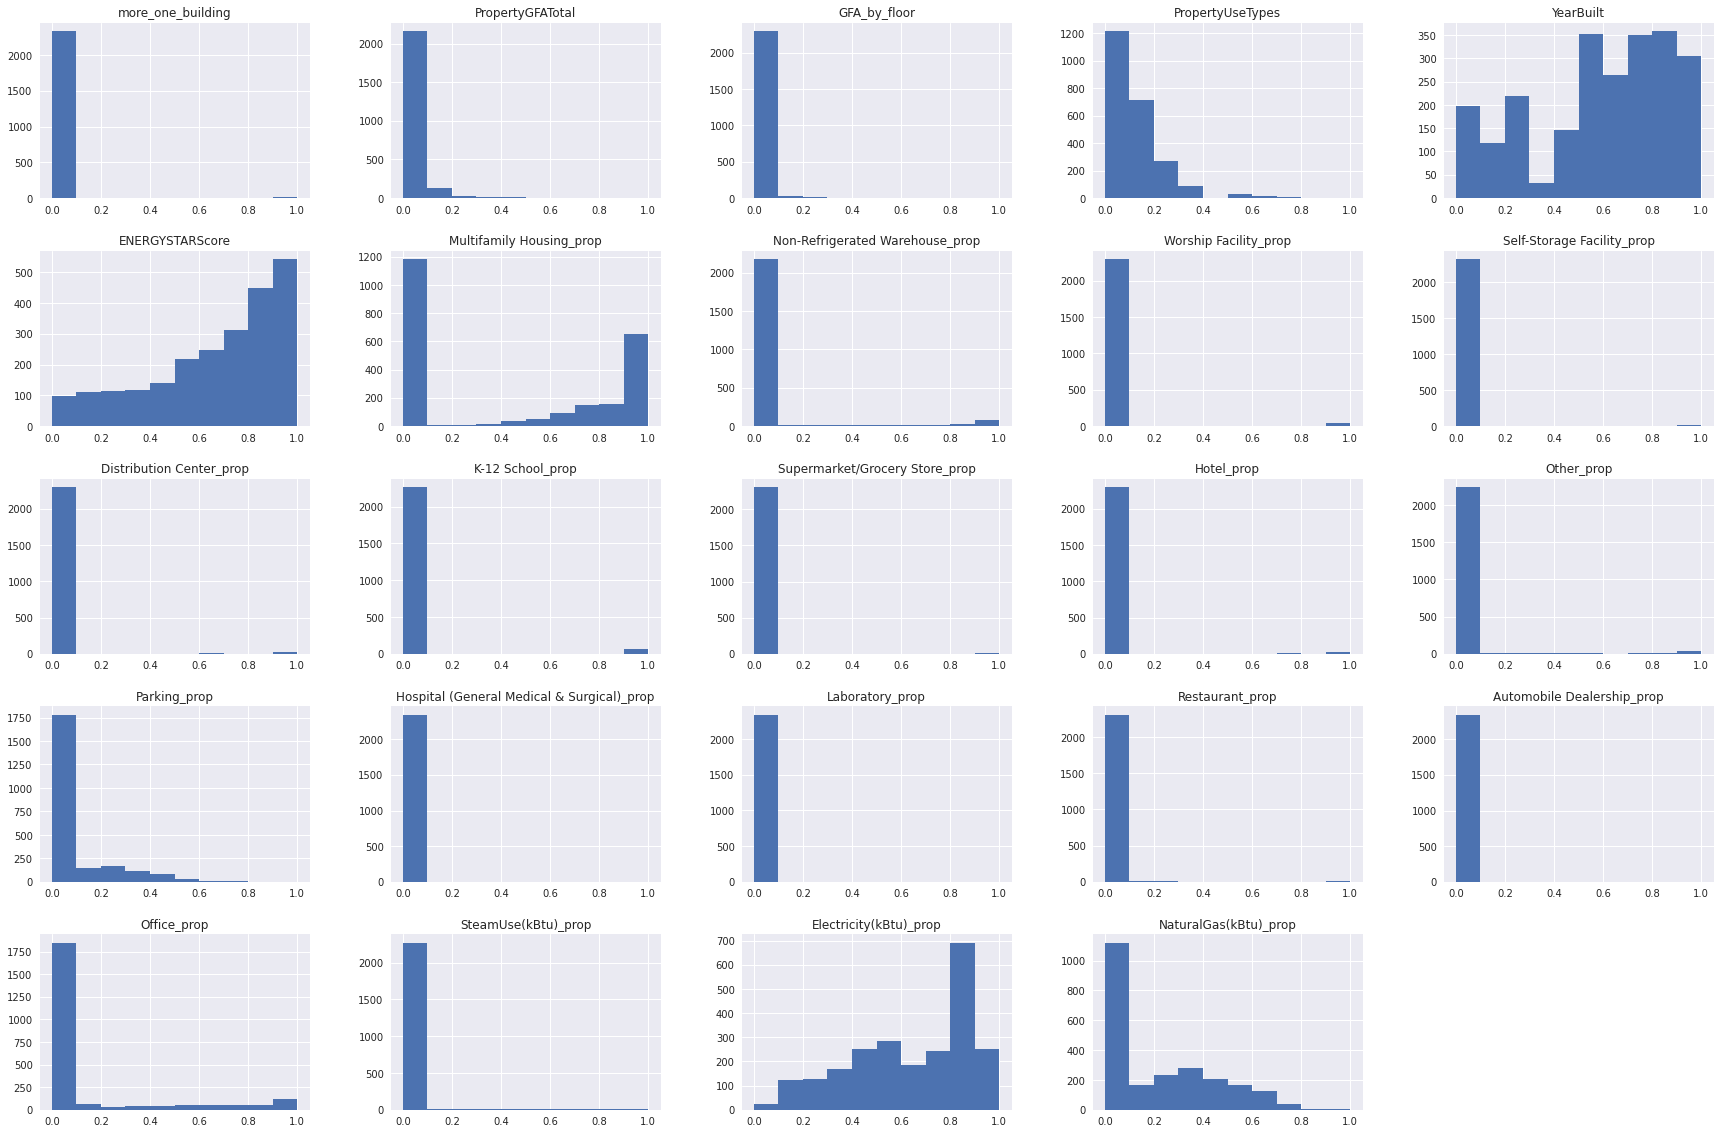

In [87]:
X_energy_train_transformed.hist(figsize=(30, 20))
plt.show()

### Construction des modèles baseline

Nous utilisons une prédiction par la moyenne comme baseline. Nous entrainons le modèle baseline pour la prédiction de consommaiton d'énergie. Nous construisons une fonction afin d'entrainer les futur modèles. Elle comprend:
- Le prétraitement des variables à prédire
- Une recherche sur grille si une liste d'hyperparamètres est fournie
- Une crossvalidation sur 5 k-folds
- l'affichage du R2 sur le jeu d'entrainement global et sur la validation croisée (sur le meilleur estimateur s'il y a une recherche sur grille)
- l'affichage du graphique comparant les valeur prédites (validation croisée) vs les labels.

Pour le modèle DummyRegressor
R2 sur le jeu d'entraînement: 0.000
Le R2 moyen de la cross validation est de -0.003 (+/-0.002)


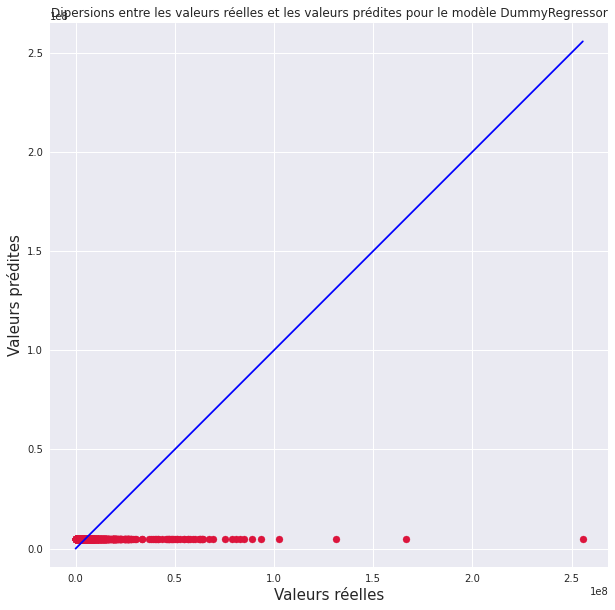

CPU times: user 130 ms, sys: 0 ns, total: 130 ms
Wall time: 126 ms


TransformedTargetRegressor(regressor=DummyRegressor(),
                           transformer=Pipeline(steps=[('Robust',
                                                        RobustScaler()),
                                                       ('MinMax',
                                                        MinMaxScaler())]))

In [189]:
%%time

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def train_evaluate_model(model, X, y, n_jobs=-1, params=None):
    """
    Train an evaluate model 
    
    Args:
        model(estimator): model to train and evaluate
        
        X(Dataframe): X_train set
        
        y(Series): y_train set
        
        scoring(string): Name of the scoring mesure to use
        
        n_jobs(int): number of jobs to run in parallel
        
        params(iterable): parameters to test in a grid search
        
    Returns:
        transformed_model(estimator): Training pipeline including transformers and a regressor 
    
    """

    
    scoring="r2"
    
  
    transformer = Pipeline(steps=[
                                  #('log',FunctionTransformer(func=np.log1p, inverse_func=np.expm1)), #To test log transformation on target variables
                                  ('Robust', RobustScaler()),
                                  ('MinMax', MinMaxScaler())
                                 ]
                          )
    
    transformed_model = TransformedTargetRegressor(regressor=model,transformer=transformer)
    
    
    if params != None:
        grid_search_model = GridSearchCV(
                                         estimator=transformed_model,
                                         param_grid=params,
                                         scoring = 'r2',
                                        n_jobs = n_jobs)
        
        grid_search_model.fit(X=X, y=y)
        grid_search_model.best_estimator_.fit(X=X, y=y)
        y_pred_train = grid_search_model.best_estimator_.predict(X=X)
        r2 =  r2_score(y_true= y, y_pred=y_pred_train)
       
        print(f"Pour le modèle {type(model).__name__}")
        print(f"Meilleurs hyper paramètres {grid_search_model.best_params_}")
        print(f"R2 sur le jeu d'entraînement {r2:.3f}")
        print(f"Le R2 moyen de la cross validation est de {grid_search_model.best_score_:.3f} (+/-{grid_search_model.cv_results_['std_test_score'][0]:.3f})")
        
        
        y_pred = cross_val_predict(grid_search_model.best_estimator_, X=X, y=y)
        
        plt.figure(figsize=(10,10))
        plt.scatter(y, y_pred, c='crimson')
        p1 = max(max(y_pred), max(y))
        p2 = min(min(y_pred), min(y))
        plt.plot([p1, p2], [p1, p2], 'b-')
        plt.xlabel('Valeurs réelles', fontsize=15)
        plt.ylabel('Valeurs prédites', fontsize=15)
        plt.axis('equal')
        plt.title(f"Dipersions entre les valeurs réelles et les valeurs prédites pour le modèle {type(model).__name__}")
        plt.show()
                
        return grid_search_model.best_estimator_
    
    else:
        transformed_model.fit(X=X, y=y)
        y_pred_train = transformed_model.predict(X=X)
        r2 = r2_score(y_true= y, y_pred=y_pred_train)
        scores = cross_val_score(transformed_model, X=X, y=y, scoring='r2')
        y_pred = cross_val_predict(transformed_model, X=X, y=y)
        print(f"Pour le modèle {type(model).__name__}")
        print(f"R2 sur le jeu d'entraînement: {r2:.3f}")
        print(f"Le R2 moyen de la cross validation est de {np.mean(scores):.3f} (+/-{np.std(scores):.3f})")
        
        
        plt.figure(figsize=(10,10))
        plt.scatter(y, y_pred, c='crimson')
        p1 = max(max(y_pred), max(y))
        p2 = min(min(y_pred), min(y))
        plt.plot([p1, p2], [p1, p2], 'b-')
        plt.xlabel('Valeurs réelles', fontsize=15)
        plt.ylabel('Valeurs prédites', fontsize=15)
        plt.axis('equal')
        plt.title(f"Dipersions entre les valeurs réelles et les valeurs prédites pour le modèle {type(model).__name__}")
        plt.show()
        
        return transformed_model
    
mean_baseline =  DummyRegressor(strategy='mean')
train_evaluate_model(mean_baseline, X_energy_train_transformed_wo_estar, y_energy_train)

Nous réalisons la même opération pour la prédiction d'émissions de CO2

Pour le modèle DummyRegressor
R2 sur le jeu d'entraînement: 0.000
Le R2 moyen de la cross validation est de -0.005 (+/-0.008)


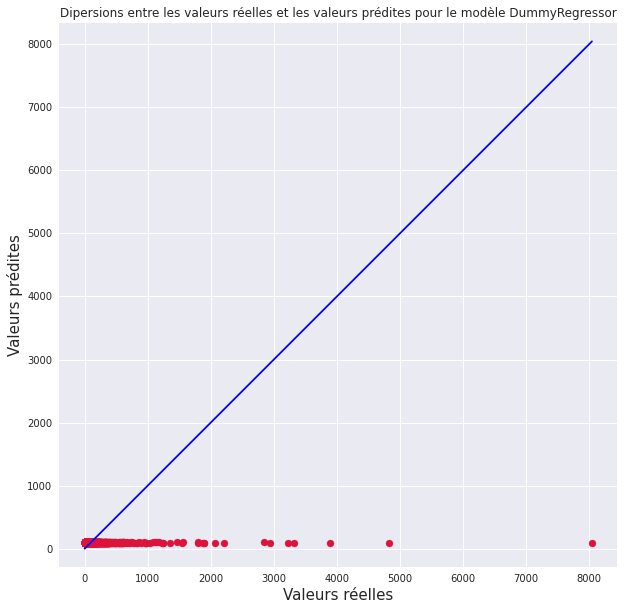

CPU times: user 131 ms, sys: 10.2 ms, total: 142 ms
Wall time: 137 ms


TransformedTargetRegressor(regressor=DummyRegressor(),
                           transformer=Pipeline(steps=[('Robust',
                                                        RobustScaler()),
                                                       ('MinMax',
                                                        MinMaxScaler())]))

In [107]:
%%time
train_evaluate_model(mean_baseline, X_co2_train_transformed_wo_estar, y_co2_train)

Sans surprise, que ce soit pour l'énergie ou le CO2, le R2 est égal ou quaisment égale à zéro.

## Entraînement des modèles

Afin de tester les variables sur les regressions linéaires, nous commençons par utiliser la librairie Statsmodels qui retourne des tests statistique à l'entrainement des models. Pour les models entrainés avec stats models nous ne réaliserons pas de cross-validation ni de graphique de comparaison. Ces models sont utilisés uniquement pour les statistiques qu'ils fournisssent.

Nous entrainerons par la suite des regression linéaires simple avec Scikit-learn par la suite afin de réaliser les crossvalidation et les graphiques.

### Regression linéaire pour la prédiction de consommation d'énergie avec Statsmodels sur l'ensemble des variables excepté "ENERGYSTARScore"

In [108]:
%%time
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
X_ols =  sm.add_constant(X_energy_train_transformed_wo_estar)
lr = OLS(y_energy_train,X_ols)
res = lr.fit()
print(res.summary())

                              OLS Regression Results                             
Dep. Variable:     SiteEnergyUseWN(kBtu)   R-squared:                       0.711
Model:                               OLS   Adj. R-squared:                  0.708
Method:                    Least Squares   F-statistic:                     248.5
Date:                   Thu, 27 May 2021   Prob (F-statistic):               0.00
Time:                           09:35:57   Log-Likelihood:                -39946.
No. Observations:                   2346   AIC:                         7.994e+04
Df Residuals:                       2322   BIC:                         8.008e+04
Df Model:                             23                                         
Covariance Type:               nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

### Regression linéaire pour la prédiction de consommation d'énergie avec Statsmodels sur l'ensemble sans la variable "ENERGYSTARScore" avec filtrage des variables avec une p-valeur suppéreure au seuil de 5%

Nous testons d'entrainer à nouveau le modèle sans  sans les variables dont la p-valeur est au dessus du seuil de 5% afin de vérifion s'il apprend mieux:
- YearBuilt
- PropertyUseTypes
- Worship Facility_prop
- Self-Storage Facility_prop
- K-12 School_prop
- Hotel_prop
- Parking_pro
- Restaurant_prop
- Automobile Dealership_prop
- Office_prop
- Electricty(kBtu)_prop 

In [143]:
from statsmodels.regression.linear_model import OLS

cols_to_drop = [
                "YearBuilt",
                "PropertyUseTypes",
                "Worship Facility_prop",
                "Self-Storage Facility_prop",
                "K-12 School_prop",
                "Hotel_prop",
                "Parking_prop",
                "Restaurant_prop",
                "Automobile Dealership_prop",
                "Office_prop",
                "Electricity(kBtu)_prop"
]

filtered_X_energy_train_transformed  = X_energy_train_transformed_wo_estar.drop(columns=cols_to_drop)
X_ols =  sm.add_constant(filtered_X_energy_train_transformed)
lr = OLS(y_energy_train,X_ols)
res = lr.fit()
print(res.summary())

                              OLS Regression Results                             
Dep. Variable:     SiteEnergyUseWN(kBtu)   R-squared:                       0.707
Model:                               OLS   Adj. R-squared:                  0.706
Method:                    Least Squares   F-statistic:                     469.9
Date:                   Thu, 27 May 2021   Prob (F-statistic):               0.00
Time:                           09:47:36   Log-Likelihood:                -39961.
No. Observations:                   2346   AIC:                         7.995e+04
Df Residuals:                       2333   BIC:                         8.002e+04
Df Model:                             12                                         
Covariance Type:               nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

Nous constatons une lègère baisse de performances sur les prédiction de consommation d'énergie. Nous répéterons l'expérience du filtrage des variables pour toutes les regression non pénalisées afin de continuer de tester l'intérêt.

### Regression linéaire pour la prédiction de consommation d'énergie avec Statsmodels en incluant la variables "ENERGYSTARScore" sans filtrage des variables 

In [110]:
%%time
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
X_ols =  sm.add_constant(X_energy_train_transformed)
lr = OLS(y_energy_train,X_ols)
res = lr.fit()
print(res.summary())

                              OLS Regression Results                             
Dep. Variable:     SiteEnergyUseWN(kBtu)   R-squared:                       0.717
Model:                               OLS   Adj. R-squared:                  0.714
Method:                    Least Squares   F-statistic:                     245.1
Date:                   Thu, 27 May 2021   Prob (F-statistic):               0.00
Time:                           09:35:59   Log-Likelihood:                -39922.
No. Observations:                   2346   AIC:                         7.989e+04
Df Residuals:                       2321   BIC:                         8.004e+04
Df Model:                             24                                         
Covariance Type:               nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

Sans filtrage des variables et avec l'ajout de la variable ENERGYSTARScore nous notons une amélioration des performances de l'odre de 0.9 points. Le gains semble faible. Nous continuerons d'évaluer l'ajout de la variable ENERGYSTarScore sur tous les models que nous allons tester.

### Regression linéaire pour la prédiction d'émission de CO2 avec Statsmodels sur l'ensemble des variables excepté "ENERGYSTARScore"

In [182]:
%%time
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
X_ols =  sm.add_constant(X_co2_train_transformed_wo_estar)
lr = OLS(y_co2_train,X_ols)
res = lr.fit()
print(res.summary())

                                 OLS Regression Results                                 
Dep. Variable:     GHGEmissions(MetricTonsCO2e)   R-squared:                       0.584
Model:                                      OLS   Adj. R-squared:                  0.580
Method:                           Least Squares   F-statistic:                     142.0
Date:                          Thu, 27 May 2021   Prob (F-statistic):               0.00
Time:                                  13:37:38   Log-Likelihood:                -15677.
No. Observations:                          2346   AIC:                         3.140e+04
Df Residuals:                              2322   BIC:                         3.154e+04
Df Model:                                    23                                         
Covariance Type:                      nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]

### Regression linéaire pour la prédiction d'émissions de CO2 avec Statsmodels sans la variable "ENERGYSTARScore" avec filtrage des variables avec une p-valeur suppéreure au seuil de 5%

In [183]:
%%time
from statsmodels.regression.linear_model import OLS
filtered_X_co2_train_transformed  = X_co2_train_transformed_wo_estar.drop(columns=cols_to_drop)
X_ols =  sm.add_constant(filtered_X_co2_train_transformed)
lr = OLS(y_co2_train,X_ols)
res = lr.fit()
print(res.summary())

                                 OLS Regression Results                                 
Dep. Variable:     GHGEmissions(MetricTonsCO2e)   R-squared:                       0.575
Model:                                      OLS   Adj. R-squared:                  0.573
Method:                           Least Squares   F-statistic:                     263.3
Date:                          Thu, 27 May 2021   Prob (F-statistic):               0.00
Time:                                  13:37:38   Log-Likelihood:                -15703.
No. Observations:                          2346   AIC:                         3.143e+04
Df Residuals:                              2333   BIC:                         3.151e+04
Df Model:                                    12                                         
Covariance Type:                      nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]

### Regression linéaire pour la prédiction d'émission de CO2 avec Statsmodels sur l'ensemble des variables incluant "ENERGYSTARScore"

In [184]:
%%time
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
X_ols =  sm.add_constant(X_co2_train_transformed)
lr = OLS(y_co2_train,X_ols)
res = lr.fit()
print(res.summary())

                                 OLS Regression Results                                 
Dep. Variable:     GHGEmissions(MetricTonsCO2e)   R-squared:                       0.590
Model:                                      OLS   Adj. R-squared:                  0.586
Method:                           Least Squares   F-statistic:                     139.3
Date:                          Thu, 27 May 2021   Prob (F-statistic):               0.00
Time:                                  13:37:38   Log-Likelihood:                -15661.
No. Observations:                          2346   AIC:                         3.137e+04
Df Residuals:                              2321   BIC:                         3.152e+04
Df Model:                                    24                                         
Covariance Type:                      nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]

#### Récapitulatif des scores

In [244]:
scores = {
            "wo_estar" : [70.8, 58.0],
            "filtered_wo_estar" : [70.6, 57.3],
            "w_estar" :[71.7, 58.6],
            "delta" : [0.9, 0.6]
         }
df_scores = pd.DataFrame(scores, columns=["wo_estar","filtered_wo_estar", "w_estar", "delta"], index=["Energie", "CO2"])
print("Comparaisons des scores R2")
df_scores

Comparaisons des scores R2


,wo_estar,filtered_wo_estar,w_estar,delta
Energie,70.8,70.6,71.7,0.9
CO2,58.0,57.3,58.6,0.6


Globalement le filtrage des variable sur la p-value ou l'ajout de l'ENERGYSTARScore changent peut les résultats sur ces modèles.

### Régression linéaire simple pour la prédiction de consommation d'énergie sans "ENERGYSTARScore"

Pour le modèle LinearRegression
R2 sur le jeu d'entraînement: 0.711
Le R2 moyen de la cross validation est de 0.570 (+/-0.122)


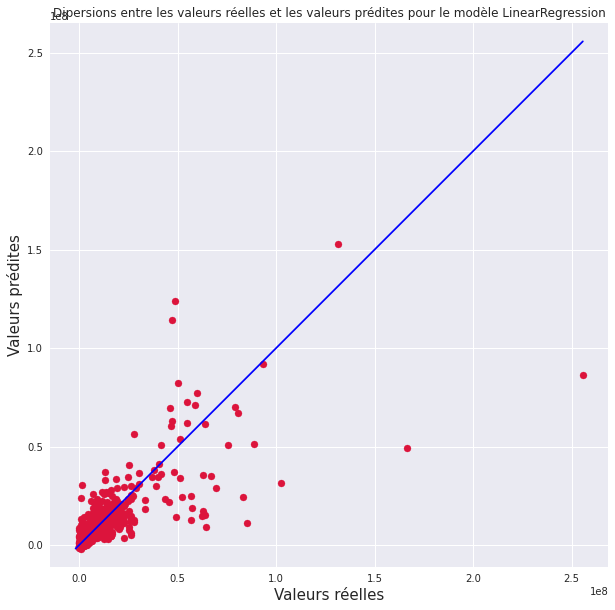

CPU times: user 933 ms, sys: 2.65 s, total: 3.58 s
Wall time: 281 ms


TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=Pipeline(steps=[('Robust',
                                                        RobustScaler()),
                                                       ('MinMax',
                                                        MinMaxScaler())]))

In [146]:
%%time
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
train_evaluate_model(lr, X_energy_train_transformed_wo_estar, y_energy_train)

### Régression linéaire simple pour la prédiction de consommation d'énergie sans "ENERGYSTARScore" et avec filtrage des variables sur les p-valeurs optenues

Pour le modèle LinearRegression
R2 sur le jeu d'entraînement: 0.707
Le R2 moyen de la cross validation est de 0.569 (+/-0.123)


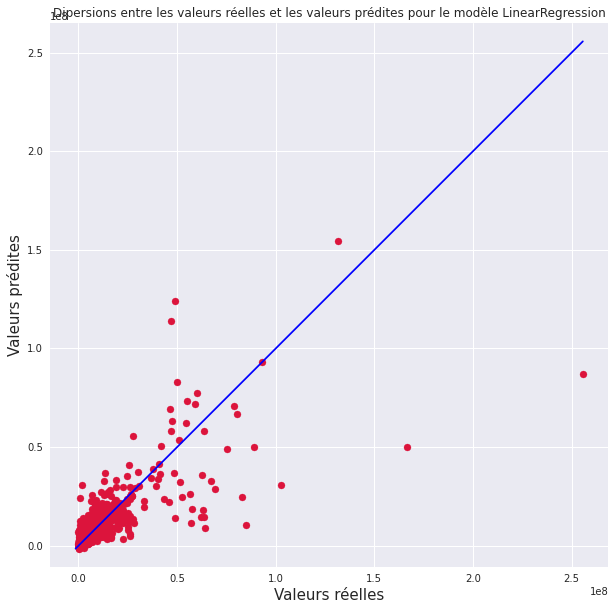

CPU times: user 467 ms, sys: 1.05 s, total: 1.52 s
Wall time: 204 ms


TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=Pipeline(steps=[('Robust',
                                                        RobustScaler()),
                                                       ('MinMax',
                                                        MinMaxScaler())]))

In [147]:
%%time
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
train_evaluate_model(lr, filtered_X_energy_train_transformed, y_energy_train)

### Régression linéaire simple pour la prédiction de consommation d'énergie avec "ENERGYSTARScore"

Pour le modèle LinearRegression
R2 sur le jeu d'entraînement: 0.717
Le R2 moyen de la cross validation est de 0.579 (+/-0.121)


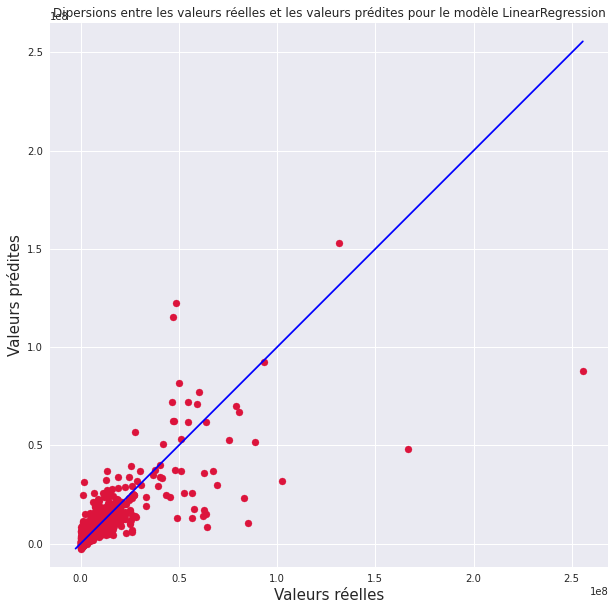

CPU times: user 857 ms, sys: 2.66 s, total: 3.52 s
Wall time: 277 ms


TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=Pipeline(steps=[('Robust',
                                                        RobustScaler()),
                                                       ('MinMax',
                                                        MinMaxScaler())]))

In [148]:
%%time
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
train_evaluate_model(lr, X_energy_train_transformed, y_energy_train)

### Régression linéaire simple pour la prédiction d'émission de CO2 sans "ENERGYSTARScore"

Pour le modèle LinearRegression
R2 sur le jeu d'entraînement: 0.711
Le R2 moyen de la cross validation est de 0.570 (+/-0.122)


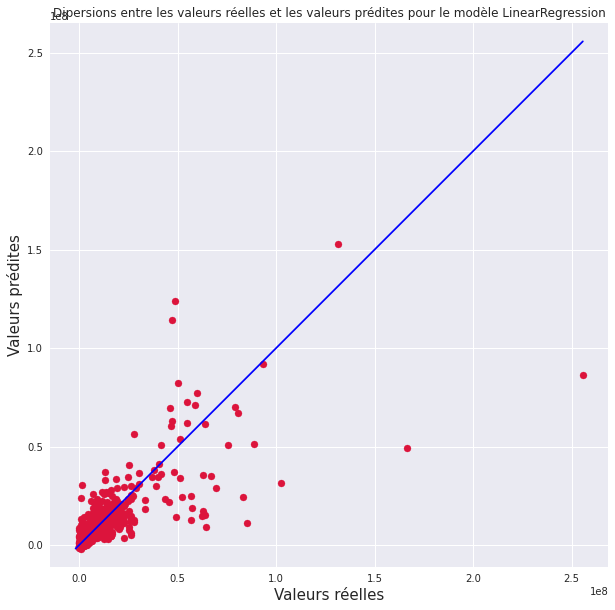

CPU times: user 872 ms, sys: 2.87 s, total: 3.74 s
Wall time: 313 ms


TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=Pipeline(steps=[('Robust',
                                                        RobustScaler()),
                                                       ('MinMax',
                                                        MinMaxScaler())]))

In [149]:
%%time
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
train_evaluate_model(lr, X_co2_train_transformed_wo_estar, y_energy_train)

### Régression linéaire simple pour la prédiction d'émission de CO2 sans "ENERGYSTARScore" et avec filtrage des variables sur les p-valeurs optenues avec Statsmodels

Pour le modèle LinearRegression
R2 sur le jeu d'entraînement: 0.707
Le R2 moyen de la cross validation est de 0.569 (+/-0.123)


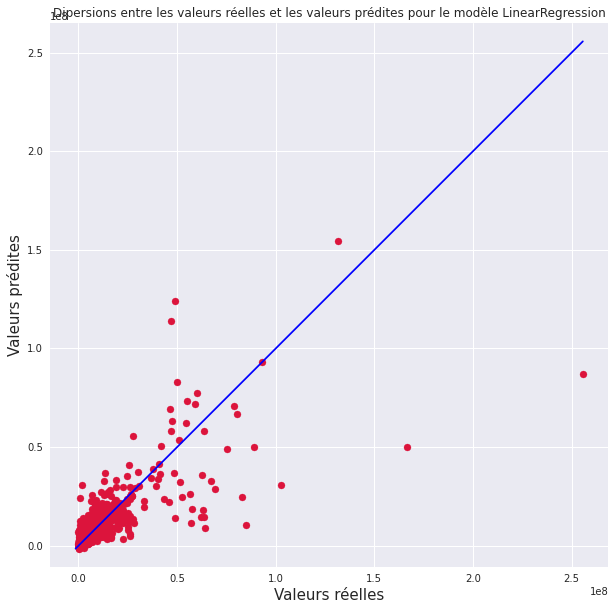

CPU times: user 390 ms, sys: 1.05 s, total: 1.44 s
Wall time: 176 ms


TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=Pipeline(steps=[('Robust',
                                                        RobustScaler()),
                                                       ('MinMax',
                                                        MinMaxScaler())]))

In [150]:
%%time
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
train_evaluate_model(lr, filtered_X_co2_train_transformed, y_energy_train)

### Régression linéaire simple pour la prédiction d'émission de CO2 avec "ENERGYSTARScore"

Pour le modèle LinearRegression
R2 sur le jeu d'entraînement: 0.717
Le R2 moyen de la cross validation est de 0.579 (+/-0.121)


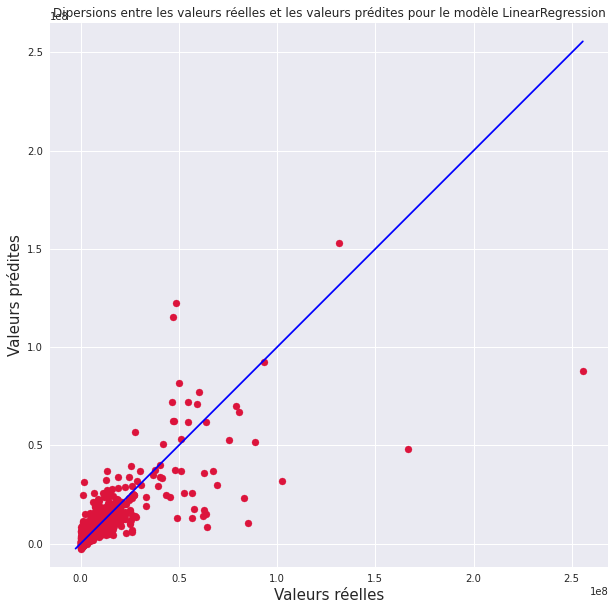

CPU times: user 869 ms, sys: 2.86 s, total: 3.73 s
Wall time: 283 ms


TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=Pipeline(steps=[('Robust',
                                                        RobustScaler()),
                                                       ('MinMax',
                                                        MinMaxScaler())]))

In [151]:
%%time
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
train_evaluate_model(lr, X_co2_train_transformed, y_energy_train)

#### Récapitulatif des scores

In [185]:
scores = {
            "wo_estar" : [57.0, 57.0],
            "filtered_wo_estar" : [56.9, 56.9],
            "w_estar" :[57.9, 57.9],
            "delta" : [0.9, 0.9]
         }
df_scores = pd.DataFrame(scores, columns=["wo_estar","filtered_wo_estar", "w_estar", "delta"], index=["Energie", "CO2"])
df_scores

,wo_estar,filtered_wo_estar,w_estar,delta
Energie,57.0,56.9,57.9,0.9
CO2,57.0,56.9,57.9,0.9


Le constat est le même l'ajout de la variable ENERGYSTARScore ou le filtrage sur les p-valeur change très peu les performances des modèlées.

### Regeression ridge pour la prédiction de consommation d'énergie sans "ENERGYSTARScore"

Pour le modèle Ridge
Meilleurs hyper paramètres {'regressor__alpha': 1.499268432786047}
R2 sur le jeu d'entraînement 0.687
Le R2 moyen de la cross validation est de 0.612 (+/-0.122)


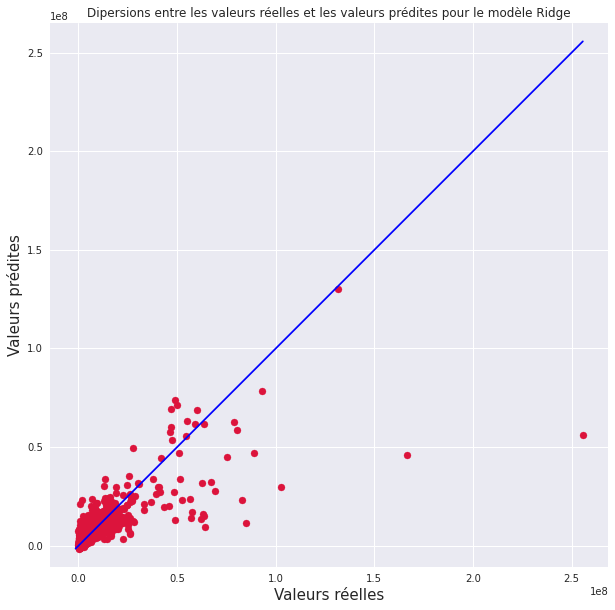

CPU times: user 1.19 s, sys: 1.83 s, total: 3.02 s
Wall time: 2.14 s


TransformedTargetRegressor(regressor=Ridge(alpha=1.499268432786047,
                                           random_state=42),
                           transformer=Pipeline(steps=[('Robust',
                                                        RobustScaler()),
                                                       ('MinMax',
                                                        MinMaxScaler())]))

In [153]:
%%time
from sklearn.linear_model import Ridge 
n_alphas = 200
params_grid = {'regressor__alpha': np.logspace(-5, 5, n_alphas)}
lr_ridge = Ridge(random_state=42)
train_evaluate_model(lr_ridge, X_energy_train_transformed_wo_estar, y_energy_train, params=params_grid)

Afin de comprendre la pondération des variables en faisant évoluer le paramètre alpha de pénalisation nous réalisons le graphique d'évolution de la pondération des variables.

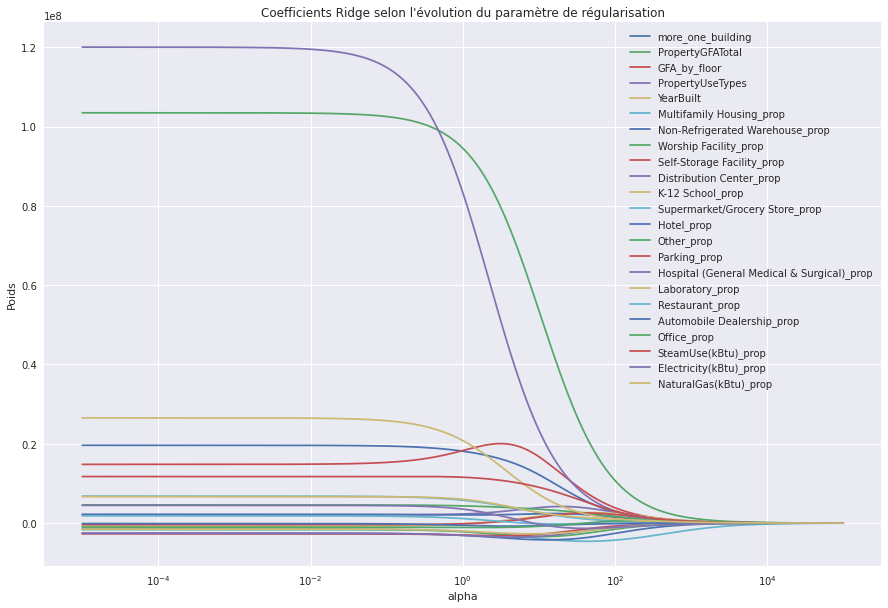

In [154]:
from sklearn.linear_model import Ridge
ridge = Ridge()

n_alphas = 200
alphas = np.logspace(-5, 5, n_alphas)

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit( X_energy_train_transformed_wo_estar, y_energy_train)
    coefs.append(ridge.coef_)


plt.figure(figsize=(15,10))
ax = plt.gca()
ax.plot(alphas, coefs)

ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('Poids')
plt.title("Coefficients Ridge selon l'évolution du paramètre de régularisation")
plt.axis('tight')
ax.legend(X_energy_train_transformed_wo_estar.columns, loc=1)
plt.show()

On constate qu'hormis les deux variables à plus forte pondération, le modèle ne pénalise qu'à partir d'une valeur alpha=0 ce qui est juste en dessous à la valeur issue la validation sur grille:  1.499268432786047.

### Regeression ridge pour la prédiction de consommation d'énergie avec "ENERGYSTARScore"

Pour le modèle Ridge
Meilleurs hyper paramètres {'regressor__alpha': 1.499268432786047}
R2 sur le jeu d'entraînement 0.693
Le R2 moyen de la cross validation est de 0.621 (+/-0.121)


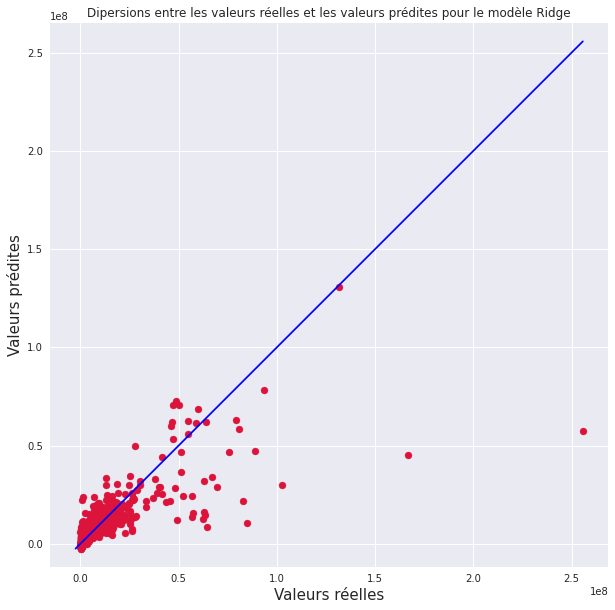

CPU times: user 1.16 s, sys: 1.91 s, total: 3.08 s
Wall time: 1.54 s


TransformedTargetRegressor(regressor=Ridge(alpha=1.499268432786047,
                                           random_state=42),
                           transformer=Pipeline(steps=[('Robust',
                                                        RobustScaler()),
                                                       ('MinMax',
                                                        MinMaxScaler())]))

In [155]:
%%time
from sklearn.linear_model import Ridge 
n_alphas = 200
params_grid = {'regressor__alpha': np.logspace(-5, 5, n_alphas)}
lr_ridge = Ridge(random_state=42)
train_evaluate_model(lr_ridge, X_energy_train_transformed, y_energy_train, params=params_grid)


### Regeression ridge pour la prédiction d'émission de CO2 sans "ENERGYSTARScore"

Pour le modèle Ridge
Meilleurs hyper paramètres {'regressor__alpha': 3.3700643292719317}
R2 sur le jeu d'entraînement 0.508
Le R2 moyen de la cross validation est de 0.422 (+/-0.340)


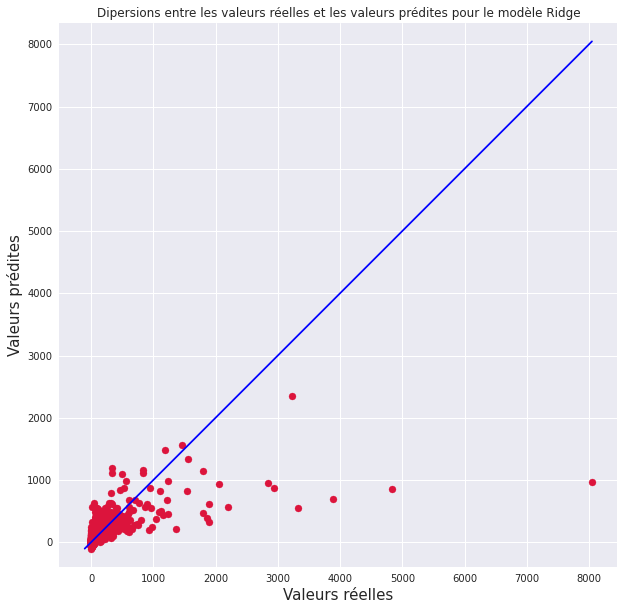

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs
CPU times: user 1.12 s, sys: 1.3 s, total: 2.41 s
Wall time: 1.46 s


In [156]:
%%time
from sklearn.linear_model import Ridge 
n_alphas = 200
params_grid = {'regressor__alpha': np.logspace(-5, 5, n_alphas)}
lr_ridge = Ridge(random_state=42)
train_evaluate_model(lr_ridge, X_co2_train_transformed_wo_estar, y_co2_train, params=params_grid)
%time

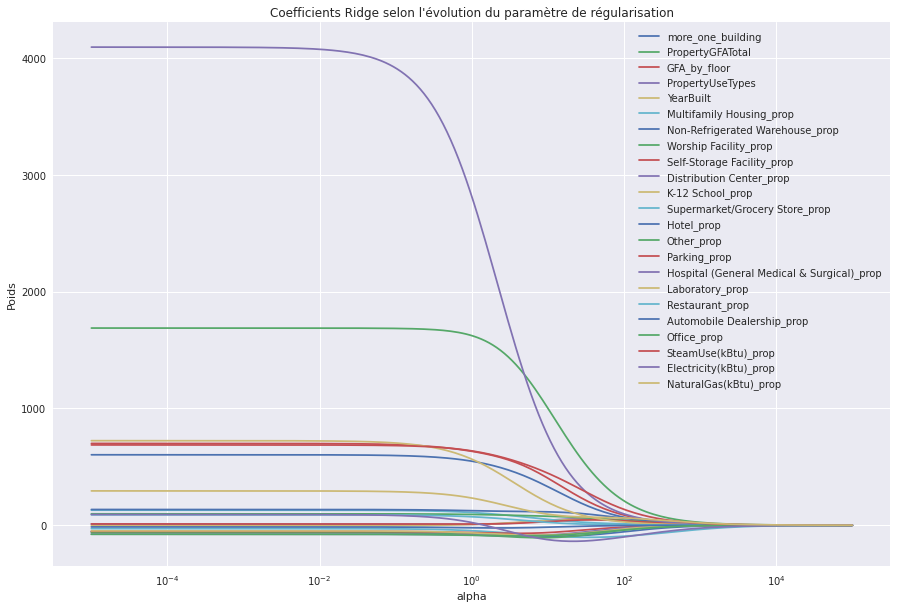

In [157]:
from sklearn.linear_model import Ridge
ridge = Ridge()

n_alphas = 200
alphas = np.logspace(-5, 5, n_alphas)

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit( X_co2_train_transformed_wo_estar, y_co2_train)
    coefs.append(ridge.coef_)


plt.figure(figsize=(15,10))
ax = plt.gca()
ax.plot(alphas, coefs)

ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('Poids')
plt.title("Coefficients Ridge selon l'évolution du paramètre de régularisation")
plt.axis('tight')
ax.legend(X_energy_train_transformed_wo_estar.columns, loc=1)
plt.show()

### Regeression ridge pour la prédiction d'émission de CO2 avec "ENERGYSTARScore"

Pour le modèle Ridge
Meilleurs hyper paramètres {'regressor__alpha': 3.3700643292719317}
R2 sur le jeu d'entraînement 0.515
Le R2 moyen de la cross validation est de 0.433 (+/-0.339)


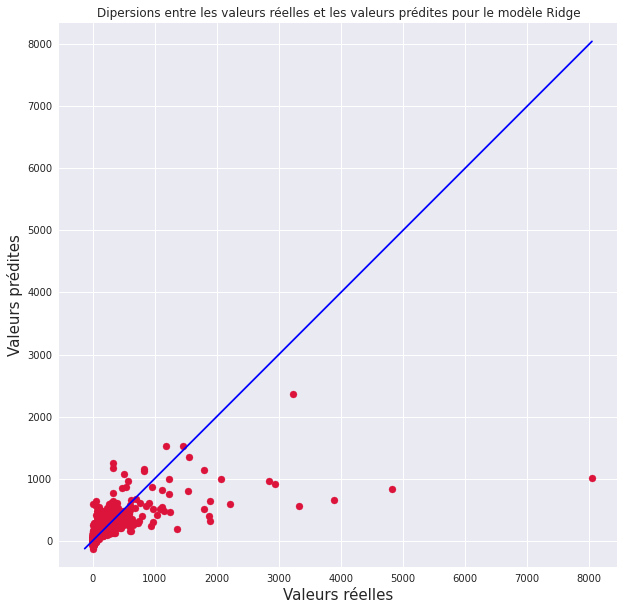

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs
CPU times: user 1.34 s, sys: 1.53 s, total: 2.87 s
Wall time: 1.55 s


In [158]:
%%time
from sklearn.linear_model import Ridge 
n_alphas = 200
params_grid = {'regressor__alpha': np.logspace(-5, 5, n_alphas)}
lr_ridge = Ridge(random_state=42)
train_evaluate_model(lr_ridge, X_co2_train_transformed, y_co2_train, params=params_grid)
%time

#### Récapitulatif des scores

In [186]:
scores = {
            "wo_estar" : [61.2, 42.2],
            "w_estar" :[62.1, 43.3],
            "delta" : [0.9, 1.1]
         }
df_scores = pd.DataFrame(scores, columns=["wo_estar", "w_estar", "delta"], index=["Energie", "CO2"])
df_scores

,wo_estar,w_estar,delta
Energie,61.2,62.1,0.9
CO2,42.2,43.3,1.1


On constate sur les regression Ridge une performance significativement moins bonne pour la prédiction de C02. Comme pour la régression non pénalisée, l'ajout de la variable ENERGYSTARScore ne permet pas de gagner significativmeent au niveau des performances.

### Regression lasso pour la prédiction d'énergie sans "ENERGYSTARScore"

Pour le modèle Lasso
Meilleurs hyper paramètres {'regressor__alpha': 0.0003107866187782014}
R2 sur le jeu d'entraînement 0.614
Le R2 moyen de la cross validation est de 0.577 (+/-0.117)


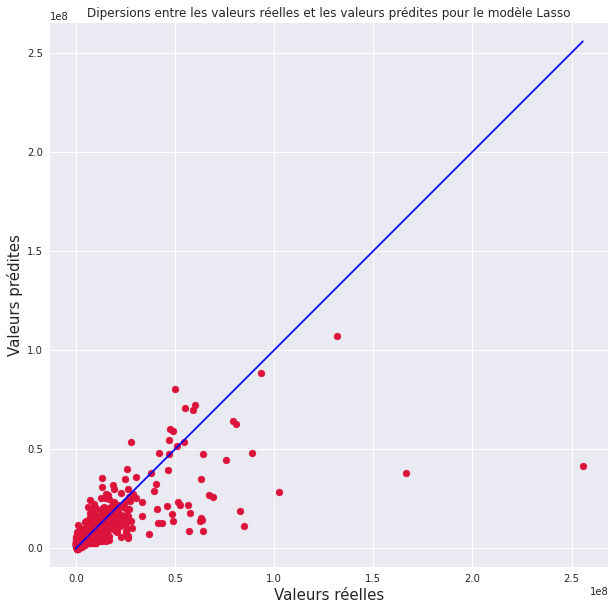

CPU times: user 1.61 s, sys: 2.73 s, total: 4.34 s
Wall time: 2.42 s


TransformedTargetRegressor(regressor=Lasso(alpha=0.0003107866187782014,
                                           random_state=42),
                           transformer=Pipeline(steps=[('Robust',
                                                        RobustScaler()),
                                                       ('MinMax',
                                                        MinMaxScaler())]))

In [160]:
%%time
from sklearn.linear_model import Lasso 
n_alphas = 200
params_grid = {'regressor__alpha': np.logspace(-5, 6, n_alphas)}
lr_lasso = Lasso(random_state=42)
train_evaluate_model(lr_lasso, X_energy_train_transformed_wo_estar, y_energy_train, params=params_grid)

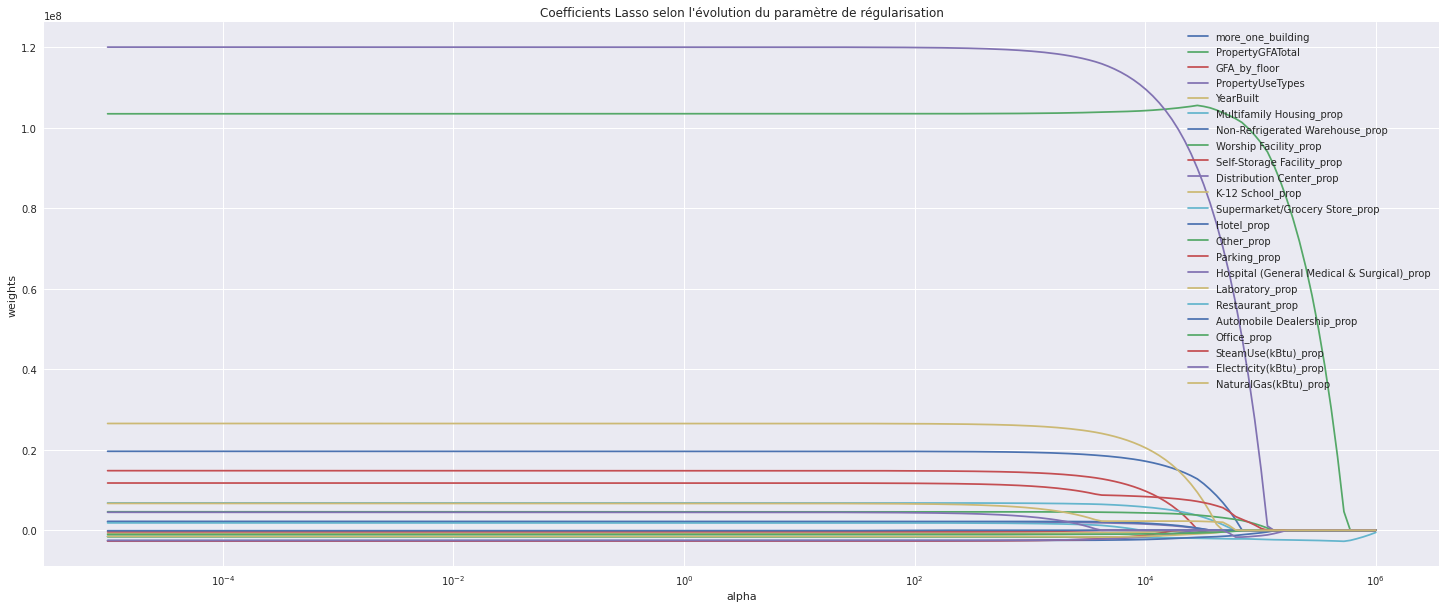

In [161]:
from sklearn.linear_model import Lasso

n_alphas = 200
alphas = np.logspace(-5, 6, n_alphas)


lasso = Lasso()

coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_energy_train_transformed_wo_estar, y_energy_train)
    coefs.append(lasso.coef_)

plt.figure(figsize=(25,10))
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title("Coefficients Lasso selon l'évolution du paramètre de régularisation")
plt.axis('tight')
ax.legend(X_energy_train_transformed_wo_estar.columns, loc=1)
plt.show()

En recoupant avec le paraètre de pénalisation alpha issue de la validation sur grille, nous constatons que les meilleur performances sont obtenues lorsque aucune variable n'est pénalisée.

### Regression lasso pour la prédiction d'énergie avec "ENERGYSTARScore"

Pour le modèle Lasso
Meilleurs hyper paramètres {'regressor__alpha': 0.0003107866187782014}
R2 sur le jeu d'entraînement 0.622
Le R2 moyen de la cross validation est de 0.591 (+/-0.116)


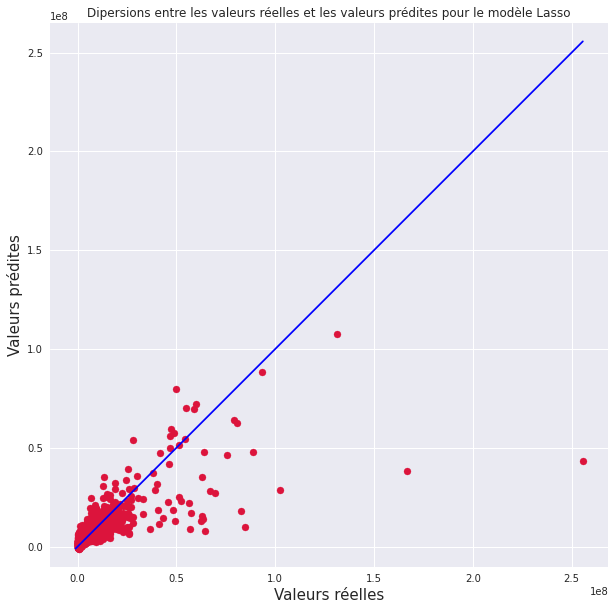

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 3.58 µs
CPU times: user 1.59 s, sys: 2.17 s, total: 3.76 s
Wall time: 2.35 s


In [162]:
%%time
from sklearn.linear_model import Lasso 
n_alphas = 200
params_grid = {'regressor__alpha': np.logspace(-5, 6, n_alphas)}
lr_lasso = Lasso(random_state=42)
train_evaluate_model(lr_lasso, X_energy_train_transformed, y_energy_train, params=params_grid)
%time

### Regression lasso pour la prédiction d'émission de CO2 sans "ENERGYSTARScore"

Pour le modèle Lasso
Meilleurs hyper paramètres {'regressor__alpha': 0.00035297073027306503}
R2 sur le jeu d'entraînement 0.427
Le R2 moyen de la cross validation est de 0.376 (+/-0.318)


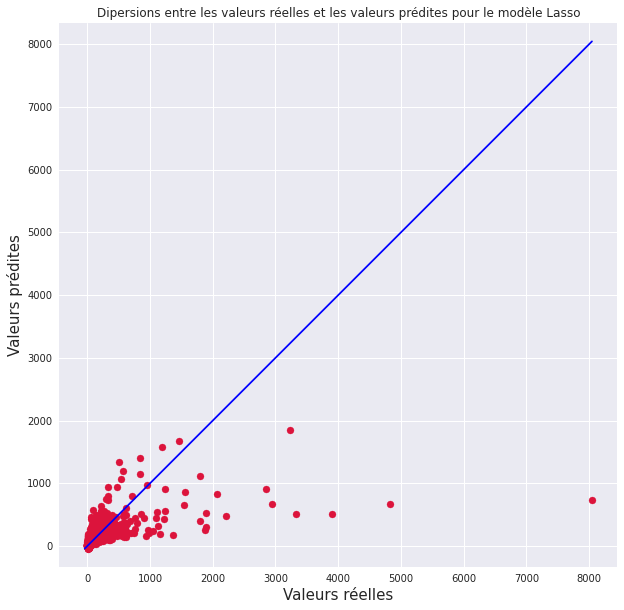

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs
CPU times: user 1.7 s, sys: 2.74 s, total: 4.44 s
Wall time: 2.3 s


In [163]:
%%time
from sklearn.linear_model import Lasso 
n_alphas = 200
params_grid = {'regressor__alpha': np.logspace(-5, 6, n_alphas)}
lr_lasso = Lasso(random_state=42, fit_intercept = False)
train_evaluate_model(lr_lasso, X_co2_train_transformed_wo_estar, y_co2_train, params=params_grid)
%time

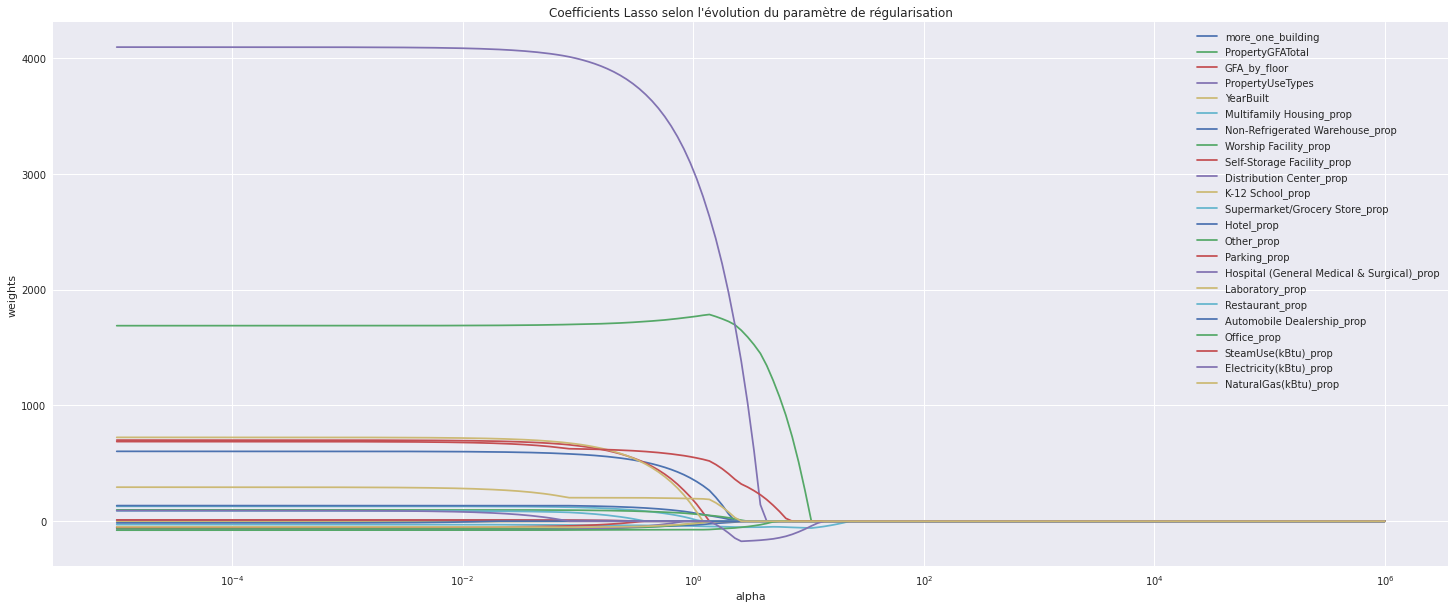

In [164]:
from sklearn.linear_model import Lasso

n_alphas = 200
alphas = np.logspace(-5, 6, n_alphas)


lasso = Lasso()

coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_co2_train_transformed_wo_estar, y_co2_train)
    coefs.append(lasso.coef_)

plt.figure(figsize=(25,10))
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title("Coefficients Lasso selon l'évolution du paramètre de régularisation")
plt.axis('tight')
ax.legend(X_co2_train_transformed_wo_estar.columns, loc=1)
plt.show()

On constate que pour la prédiction de CO2, la pénalisation intervient beaucoup plus tôt. De plus sur avec une valeur retournée par la valisation sur grille (00035297073027306503) on constate que les variables aux poids les plus forts sont déjà pénalisés.

### Regression lasso pour la prédiction d'émission de CO2 avec "ENERGYSTARScore"

Pour le modèle Lasso
Meilleurs hyper paramètres {'regressor__alpha': 0.00035297073027306503}
R2 sur le jeu d'entraînement 0.431
Le R2 moyen de la cross validation est de 0.383 (+/-0.319)


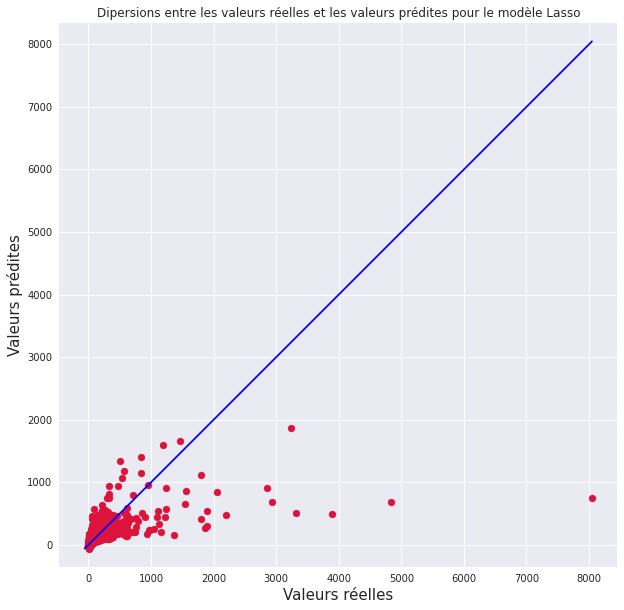

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 3.81 µs
CPU times: user 1.49 s, sys: 2.2 s, total: 3.69 s
Wall time: 2.47 s


In [165]:
%%time
from sklearn.linear_model import Lasso 
n_alphas = 200
params_grid = {'regressor__alpha': np.logspace(-5, 6, n_alphas)}
lr_lasso = Lasso(random_state=42, fit_intercept = False)
train_evaluate_model(lr_lasso, X_co2_train_transformed, y_co2_train, params=params_grid)
%time

#### Récapitulatif des scores

In [237]:
scores = {
            "wo_estar" : [57.7, 37.6],
            "w_estar" :[59.1, 38.3],
            "delta" : [1.7, 0.7]
         }
df_scores = pd.DataFrame(scores, columns=["wo_estar", "w_estar", "delta"], index=["Energie", "CO2"])
df_scores

,wo_estar,w_estar,delta
Energie,57.7,59.1,1.7
CO2,37.6,38.3,0.7


Comme pour la regression Ridge, les performances sont moins bonnes pour la prédiction d'émissions de CO2. Encore une fois l'ajout de la variable ENERGYSTARScore n'apporte pas un gain de performance significatif.

### SVM linéaire pour la prédiction de consommation d'énergie sans "ENERGYSTARScore"

Pour le modèle LinearSVR
Meilleurs hyper paramètres {'regressor__C': 0.46415888336127775}
R2 sur le jeu d'entraînement 0.696
Le R2 moyen de la cross validation est de 0.611 (+/-0.035)


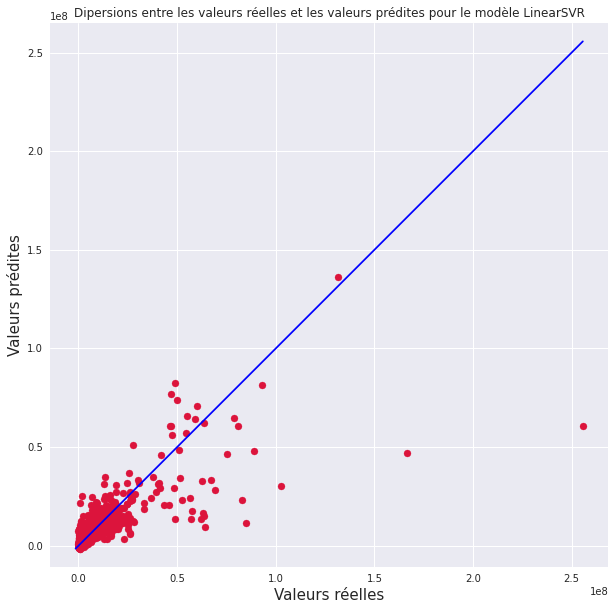

CPU times: user 474 ms, sys: 1.76 s, total: 2.24 s
Wall time: 333 ms


TransformedTargetRegressor(regressor=LinearSVR(C=0.46415888336127775,
                                               dual=False,
                                               loss='squared_epsilon_insensitive',
                                               random_state=42),
                           transformer=Pipeline(steps=[('Robust',
                                                        RobustScaler()),
                                                       ('MinMax',
                                                        MinMaxScaler())]))

In [167]:
%%time
from sklearn.svm import LinearSVR
params_grid = {'regressor__C':np.logspace(-3,3,10)}

lin_svr = LinearSVR(dual=False, loss='squared_epsilon_insensitive', random_state=42)
train_evaluate_model(lin_svr, X_energy_train_transformed_wo_estar, y_energy_train, params=params_grid)


### SVM linéaire pour la prédiction de consommation d'énergie avec "ENERGYSTARScore"

Pour le modèle LinearSVR
R2 sur le jeu d'entraînement: 0.702
Le R2 moyen de la cross validation est de 0.619 (+/-0.070)


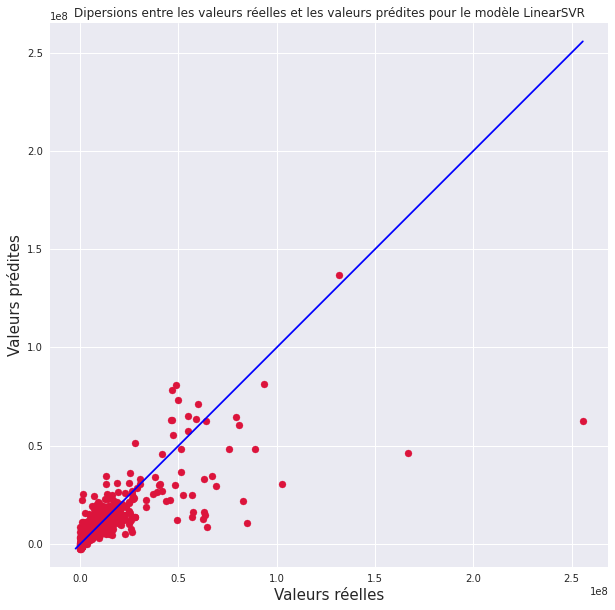

CPU times: user 923 ms, sys: 2.76 s, total: 3.68 s
Wall time: 297 ms


TransformedTargetRegressor(regressor=LinearSVR(C=0.46415888336127775,
                                               dual=False,
                                               loss='squared_epsilon_insensitive',
                                               random_state=42),
                           transformer=Pipeline(steps=[('Robust',
                                                        RobustScaler()),
                                                       ('MinMax',
                                                        MinMaxScaler())]))

In [168]:
%%time
from sklearn.svm import LinearSVR
lin_svr = LinearSVR(dual=False, loss='squared_epsilon_insensitive', C = 0.46415888336127775 ,random_state=42)
train_evaluate_model(lin_svr, X_energy_train_transformed, y_energy_train)

### SVM linéaire pour la prédiction dé'émission de CO2 d'énergie sans "ENERGYSTARScore"

Pour le modèle LinearSVR
Meilleurs hyper paramètres {'regressor__C': 0.1}
R2 sur le jeu d'entraînement 0.478
Le R2 moyen de la cross validation est de 0.418 (+/-0.046)


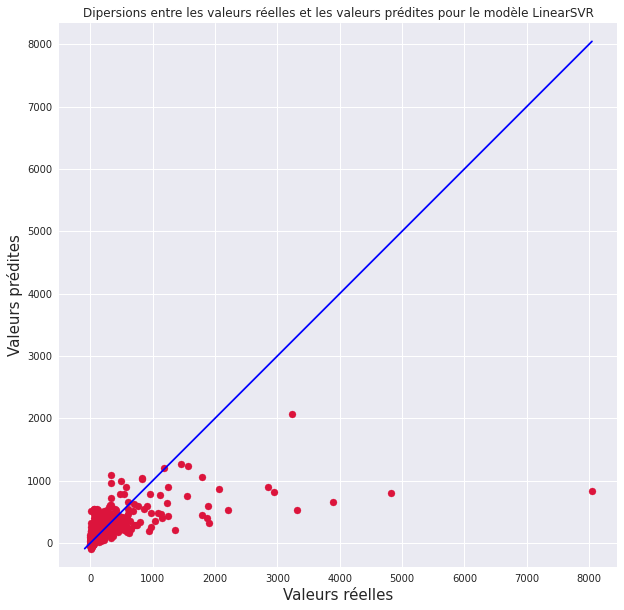

CPU times: user 613 ms, sys: 1.48 s, total: 2.09 s
Wall time: 323 ms


TransformedTargetRegressor(regressor=LinearSVR(C=0.1, dual=False,
                                               loss='squared_epsilon_insensitive',
                                               random_state=42),
                           transformer=Pipeline(steps=[('Robust',
                                                        RobustScaler()),
                                                       ('MinMax',
                                                        MinMaxScaler())]))

In [169]:
%%time
from sklearn.svm import LinearSVR
params_grid = {'regressor__C': np.logspace(-3,3,10)}
lin_svr = LinearSVR(dual=False, loss='squared_epsilon_insensitive', random_state=42)
train_evaluate_model(lin_svr, X_co2_train_transformed_wo_estar, y_co2_train, params=params_grid)

### SVM linéaire pour la prédiction dé'émission de CO2 d'énergie avec "ENERGYSTARScore"

Pour le modèle LinearSVR
R2 sur le jeu d'entraînement: 0.622
Le R2 moyen de la cross validation est de 0.580 (+/-0.080)


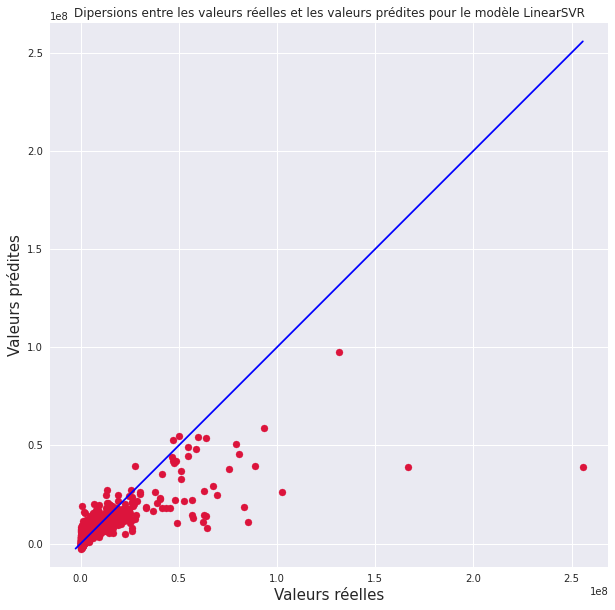

CPU times: user 1.03 s, sys: 3.38 s, total: 4.41 s
Wall time: 339 ms


TransformedTargetRegressor(regressor=LinearSVR(C=0.1, dual=False,
                                               loss='squared_epsilon_insensitive',
                                               random_state=42),
                           transformer=Pipeline(steps=[('Robust',
                                                        RobustScaler()),
                                                       ('MinMax',
                                                        MinMaxScaler())]))

In [170]:
%%time
from sklearn.svm import LinearSVR
lin_svr = LinearSVR(dual=False, loss='squared_epsilon_insensitive', C = 0.1 ,random_state=42)
train_evaluate_model(lin_svr, X_co2_train_transformed, y_energy_train)

#### Récapitulatif des scores

In [233]:
scores = {
            "wo_estar" : [61.1, 47.8],
            "w_estar" :[70.2, 62.2],
            "delta" : [9.1, 14.4]
         }
df_scores = pd.DataFrame(scores, columns=["wo_estar", "w_estar", "delta"], index=["Energie", "CO2"])
df_scores

,wo_estar,w_estar,delta
Energie,61.1,70.2,9.1
CO2,47.8,62.2,14.4


Nous notons pour la prédiction de CO2, l'ajout de la variable ENERGYSTARSCore apporte un gain de performance de que 14.8 points. Hormis ce phénomène, les performances sont dans un ordre de grandeur proche des autres modèles linéaires.

### SVM à noyeaux pour la prédiction d'énergie sans "ENERGYSTARScore"

Pour le modèle SVR
Meilleurs hyper paramètres {'regressor__C': 233.57214690901213, 'regressor__degree': 2, 'regressor__kernel': 'poly'}
R2 sur le jeu d'entraînement -0.289
Le R2 moyen de la cross validation est de -0.577 (+/-2.618)


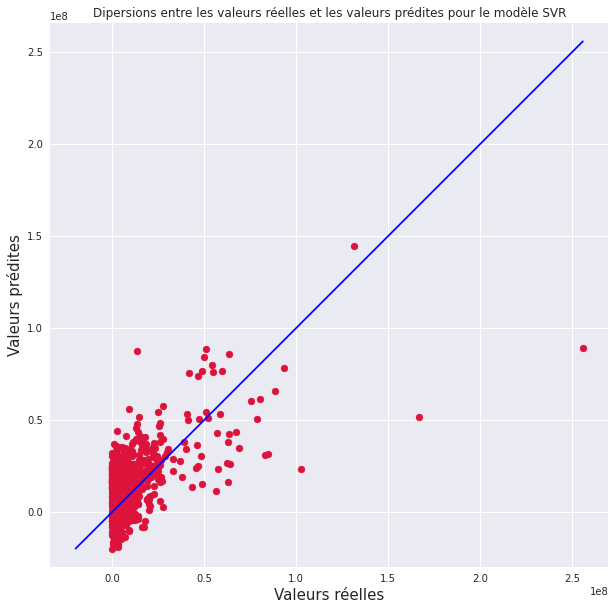

CPU times: user 1.47 s, sys: 383 ms, total: 1.85 s
Wall time: 8.2 s


TransformedTargetRegressor(regressor=SVR(C=233.57214690901213, degree=2,
                                         kernel='poly'),
                           transformer=Pipeline(steps=[('Robust',
                                                        RobustScaler()),
                                                       ('MinMax',
                                                        MinMaxScaler())]))

In [250]:
%%time
from sklearn.svm import SVR
params_grid = {'regressor__kernel': ['poly', 'rbf', 'sigmoid'],
              'regressor__degree': [2,5,10],
              'regressor__C': np.logspace(-3,3,20)
            }
svr = SVR()
train_evaluate_model(svr, X_energy_train_transformed_wo_estar, y_energy_train, params=params_grid)

### SVM à noyeaux pour la prédiction d'énergie avec "ENERGYSTARScore"

Pour le modèle SVR
R2 sur le jeu d'entraînement: -0.181
Le R2 moyen de la cross validation est de -0.596 (+/-0.652)


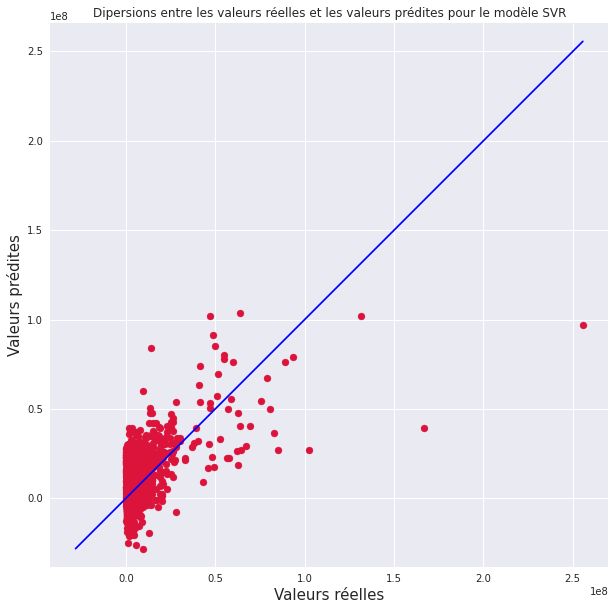

CPU times: user 759 ms, sys: 0 ns, total: 759 ms
Wall time: 760 ms


TransformedTargetRegressor(regressor=SVR(C=233.57214690901213, degree=2,
                                         kernel='poly'),
                           transformer=Pipeline(steps=[('Robust',
                                                        RobustScaler()),
                                                       ('MinMax',
                                                        MinMaxScaler())]))

In [251]:
%%time
from sklearn.svm import SVR
svr = SVR(C=233.57214690901213, degree = 2, kernel = 'poly')
train_evaluate_model(svr, X_energy_train_transformed, y_energy_train)

### SVM à noyeaux pour la prédiction d'émission de CO2 sans "ENERGYSTARScore"

Pour le modèle SVR
Meilleurs hyper paramètres {'regressor__C': 6.158482110660261, 'regressor__degree': 2, 'regressor__kernel': 'poly'}
R2 sur le jeu d'entraînement -0.161
Le R2 moyen de la cross validation est de -1.393 (+/-8.234)


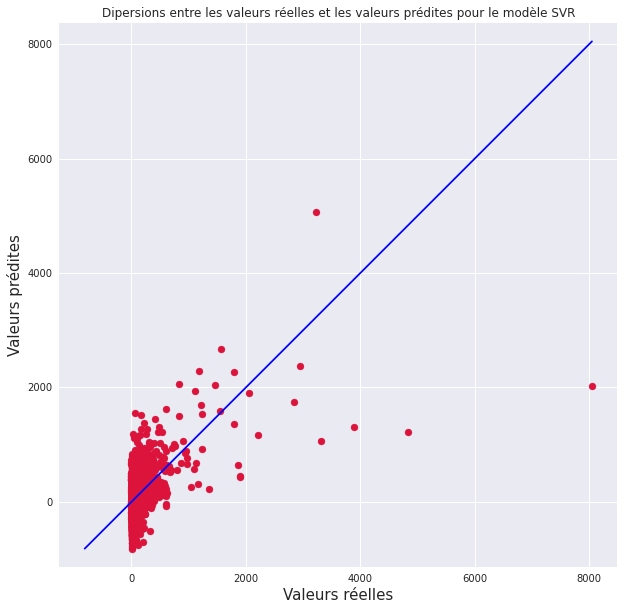

CPU times: user 1.06 s, sys: 37.6 ms, total: 1.09 s
Wall time: 6.46 s


TransformedTargetRegressor(regressor=SVR(C=6.158482110660261, degree=2,
                                         kernel='poly'),
                           transformer=Pipeline(steps=[('Robust',
                                                        RobustScaler()),
                                                       ('MinMax',
                                                        MinMaxScaler())]))

In [252]:
%%time
from sklearn.svm import SVR
params_grid = {'regressor__kernel': ['poly', 'rbf', 'sigmoid'],
              'regressor__degree': [2,5,10],
              'regressor__C': np.logspace(-3,3,20)
            }
svr = SVR()
train_evaluate_model(svr, X_co2_train_transformed_wo_estar, y_co2_train,params=params_grid)

### SVM à noyeaux pour la prédiction d'émission de CO2 avec "ENERGYSTARScore"

Pour le modèle SVR
R2 sur le jeu d'entraînement: -0.122
Le R2 moyen de la cross validation est de -0.647 (+/-0.650)


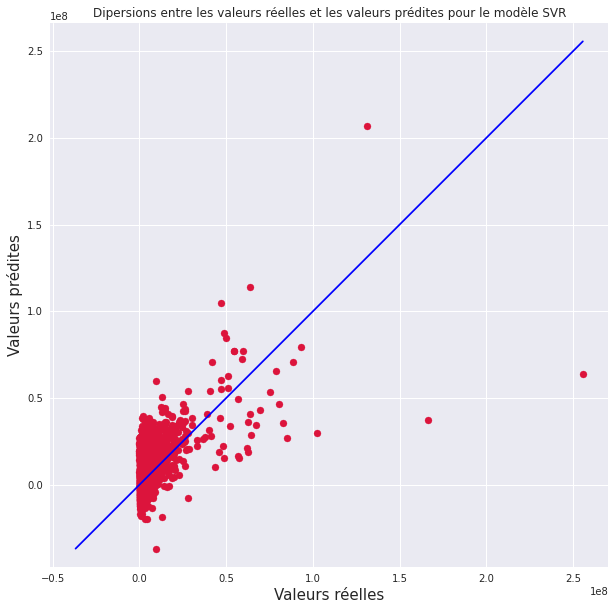

CPU times: user 390 ms, sys: 0 ns, total: 390 ms
Wall time: 387 ms


TransformedTargetRegressor(regressor=SVR(C=6.158482110660261, degree=2,
                                         kernel='poly'),
                           transformer=Pipeline(steps=[('Robust',
                                                        RobustScaler()),
                                                       ('MinMax',
                                                        MinMaxScaler())]))

In [254]:
%%time
from sklearn.svm import SVR
svr = SVR(C =6.158482110660261, degree = 2, kernel = 'poly')
train_evaluate_model(svr, X_co2_train_transformed, y_energy_train)

#### Récapitulatif des scores

In [176]:
scores = {
            "wo_estar" :[-57.7, -1.39],
            "w_estar" :[-59.6, -0.65],
            "delta" : [-1.9, -0.74]
         }
df_scores = pd.DataFrame(scores, columns=["wo_estar", "w_estar", "delta"], index=["Energie", "CO2"])
df_scores

,wo_estar,w_estar,delta
Energie,-27.4,-33.2,-5.8
CO2,-179.6,-46.8,132.8


L'interprétation de la métrique est contre intuitive. Avec des R2 négatif, les résultats sous-entends que ces modèle fournissent des prédictions bien moins bonnes qu'une constante. Ces modèles sont coûteux a entraîner et nécessietent de tester de nombreux hyperparamètres pour trouver le meilleur noyeaux et combinaisons d'hyper paramètres associés. Etant donné les résulats de la SVM linéaire et les liaisons entre entre les variables en entrée et la varoable cible nous ne poursuivrons pas dans cette direction. 

### Random forest pour la prédiction de consommation d'énergie sans "ENERGYSTARScore"

/home/cedric/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Pour le modèle RandomForestRegressor
Meilleurs hyper paramètres {'regressor__bootstrap': True, 'regressor__max_depth': None, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 800}
R2 sur le jeu d'entraînement 0.970
Le R2 moyen de la cross validation est de 0.745 (+/-0.074)


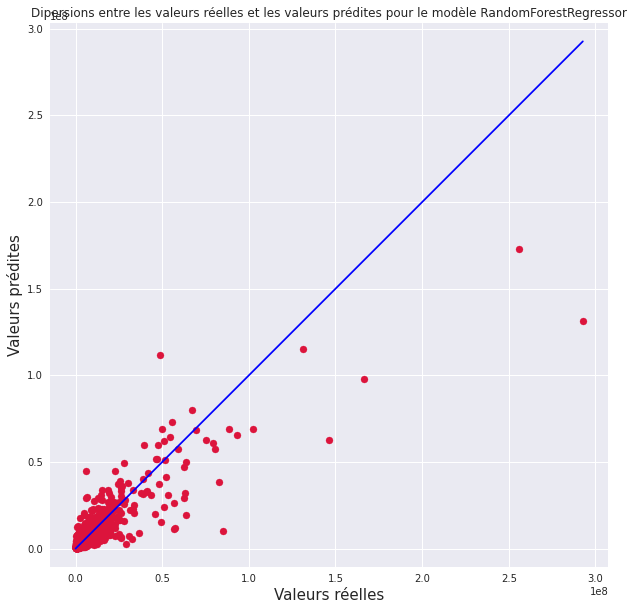

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs
CPU times: user 1min 43s, sys: 10.8 s, total: 1min 54s
Wall time: 4h 18min 35s


In [18]:
%%time
from sklearn.ensemble import RandomForestRegressor
params_grid = {'regressor__bootstrap': [True, False],
              'regressor__max_depth': [1,3,4,5,6,None],
              'regressor__max_features': ['auto', 'sqrt'],
              'regressor__min_samples_leaf': [1, 2, 4, 6, 8, 10],
              'regressor__min_samples_split': [2, 4, 5, 6, 10],
              'regressor__n_estimators' : [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
              }
rf = RandomForestRegressor(random_state=42)
train_evaluate_model(rf, X_energy_train_transformed_wo_estar, y_energy_train, params=params_grid)


Le milleur estimateur ayant une hyperparamètres max_depth à "None", nous décions d'affiner la recherche de paramètres en testant sur des valeur suppérieures sur ce paramètre.

Pour le modèle RandomForestRegressor
Meilleurs hyper paramètres {'regressor__max_depth': 12, 'regressor__n_estimators': 1400}
R2 sur le jeu d'entraînement 0.962
Le R2 moyen de la cross validation est de 0.746 (+/-0.085)


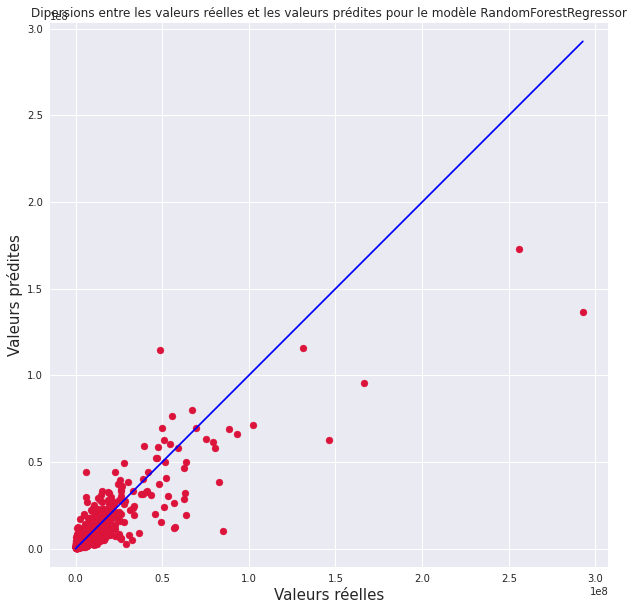

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.62 µs
CPU times: user 55.7 s, sys: 0 ns, total: 55.7 s
Wall time: 8min 32s


In [23]:
%%time
from sklearn.ensemble import RandomForestRegressor
params_grid = {
              'regressor__max_depth': [6,7,8,9,10,11,12,13,14,15],
              'regressor__n_estimators' : [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
              }
rf = RandomForestRegressor(random_state=42, bootstrap=True, max_features='auto', min_samples_leaf=1, min_samples_split=2 )
train_evaluate_model(rf, X_energy_train_transformed_wo_estar, y_energy_train, params=params_grid)


Nous constatons effectivement une très légère augmentation de performances. Afin de mieux expliquer ce modèle, nous affichons sa feature importance.

In [32]:
feature_importance_dict = {}
feature_importance_dict["Variable"] = []
feature_importance_dict["Score"] = []

rf = RandomForestRegressor(random_state=42, bootstrap=True, max_features='auto', max_depth = 12,  min_samples_leaf=1, min_samples_split=2, n_estimators = 1400)
rf.fit(X=X_energy_train_transformed_wo_estar, y=y_energy_train)

for name, score in zip(X_energy_train_transformed_wo_estar.columns, rf.feature_importances_):
    feature_importance_dict["Variable"].append(name)
    feature_importance_dict["Score"].append(score)

rf_energy_feature_importance = pd.DataFrame(feature_importance_dict, columns = ["Score"], index=feature_importance_dict["Variable"]).sort_values(by="Score", ascending = False, axis=0)
rf_energy_feature_importance

,Score
PropertyGFATotal,0.501945
Hospital (General Medical & Surgical)_prop,0.236309
Electricity(kBtu)_prop,0.075688
Other_prop,0.031854
NaturalGas(kBtu)_prop,0.023104
SteamUse(kBtu)_prop,0.020881
PropertyUseTypes,0.020833
YearBuilt,0.017230
GFA_by_floor,0.015079
Laboratory_prop,0.014357


Nous constatons que la surface totale à une importance bien suppérieures à tous les autres paramètres. Viennent ensuite rapidement les proportions de consommation par type d'énergie. Hormis quelques expection les proportions d'activités sont peu significatives dans ce modèle.

### Random forest pour la prédiction de consommation d'énergie avec "ENERGYSTARScore"

Pour le modèle RandomForestRegressor
R2 sur le jeu d'entraînement: 0.965
Le R2 moyen de la cross validation est de 0.750 (+/-0.074)


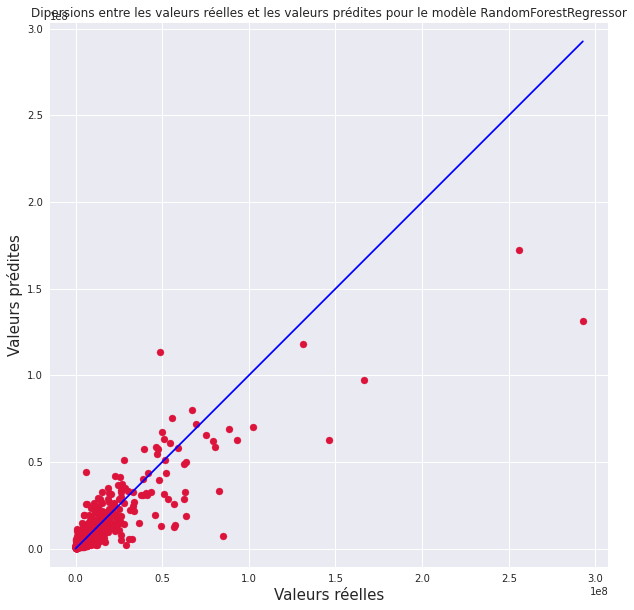

CPU times: user 1min 31s, sys: 0 ns, total: 1min 31s
Wall time: 1min 31s


TransformedTargetRegressor(regressor=RandomForestRegressor(max_depth=12,
                                                           n_estimators=1400,
                                                           random_state=42),
                           transformer=Pipeline(steps=[('Robust',
                                                        RobustScaler()),
                                                       ('MinMax',
                                                        MinMaxScaler())]))

In [33]:
%%time
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=42, bootstrap=True, max_features='auto', max_depth = 12,  min_samples_leaf=1, min_samples_split=2, n_estimators = 1400)
train_evaluate_model(rf, X_energy_train_transformed, y_energy_train)

### Random forest pour la prédiction d'émission de CO2 sans "ENERGYSTARScore"

/home/cedric/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Pour le modèle RandomForestRegressor
Meilleurs hyper paramètres {'regressor__max_depth': None, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 800}
R2 sur le jeu d'entraînement 0.764
Le R2 moyen de la cross validation est de 0.654 (+/-0.730)


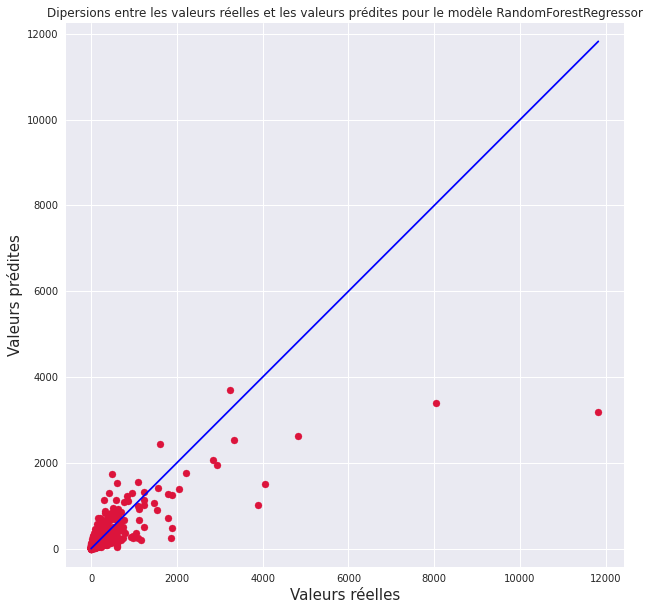

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs
CPU times: user 46.2 s, sys: 2.67 s, total: 48.9 s
Wall time: 1h 19min 38s


In [22]:
%%time
from sklearn.ensemble import RandomForestRegressor
params_grid = {
              'regressor__max_depth': [1,3,4,5,6,None],
              'regressor__min_samples_leaf': [1, 2, 4, 6, 8, 10],
              'regressor__min_samples_split': [2, 4, 5, 6, 10],
              'regressor__n_estimators' : [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
              }
rf = RandomForestRegressor(bootstrap=True, max_features='auto', random_state=42)
train_evaluate_model(rf, X_co2_train_transformed_wo_estar, y_co2_train, params=params_grid)


Comme pour la prédiction d'énergie, nous affions la recherche sur grille pour trouver un paramètres max_depth différent de "None"

Pour le modèle RandomForestRegressor
Meilleurs hyper paramètres {'regressor__max_depth': 11, 'regressor__n_estimators': 800}
R2 sur le jeu d'entraînement 0.845
Le R2 moyen de la cross validation est de 0.714 (+/-0.068)


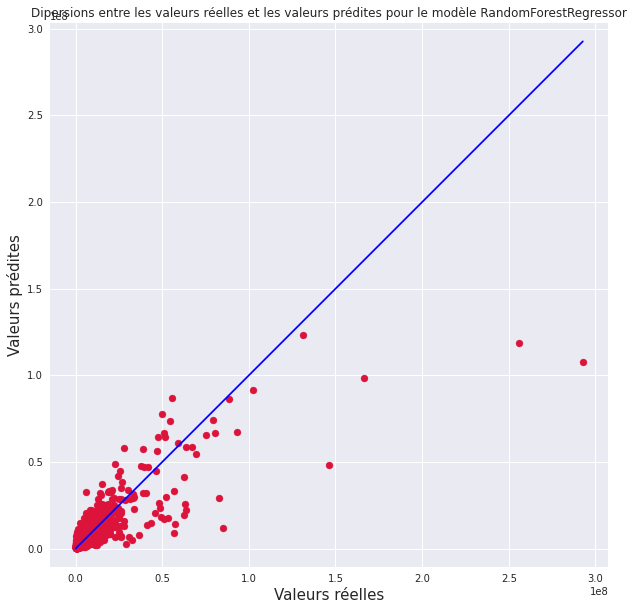

CPU times: user 28.9 s, sys: 37.3 ms, total: 28.9 s
Wall time: 7min 35s


TransformedTargetRegressor(regressor=RandomForestRegressor(max_depth=11,
                                                           min_samples_leaf=4,
                                                           n_estimators=800,
                                                           random_state=42),
                           transformer=Pipeline(steps=[('Robust',
                                                        RobustScaler()),
                                                       ('MinMax',
                                                        MinMaxScaler())]))

In [39]:
%%time
from sklearn.ensemble import RandomForestRegressor
params_grid = {
              'regressor__max_depth': [6,7,8,9,10,11,12,13,14,15],
              'regressor__n_estimators' : [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
              }
rf = RandomForestRegressor(random_state=42, bootstrap=True, max_features='auto', min_samples_leaf=4, min_samples_split=2 )
train_evaluate_model(rf, X_co2_train_transformed_wo_estar, y_energy_train, params=params_grid)


A l'image de la prédiction d'énergie le R2 est amélioré. Ici l'ordre de grandeur est plus significatif avec une amélioration de 5.7 points. Noius affichons également la feature importance du modèle afin de mieux l'expliquer.

In [42]:
feature_importance_dict = {}
feature_importance_dict["Variable"] = []
feature_importance_dict["Score"] = []

rf = RandomForestRegressor(random_state=42, bootstrap=True, max_features='auto', max_depth = 11,  min_samples_leaf=4, min_samples_split=2, n_estimators = 1400)
rf.fit(X=X_co2_train_transformed_wo_estar, y=y_co2_train)

for name, score in zip(X_energy_train_transformed_wo_estar.columns, rf.feature_importances_):
    feature_importance_dict["Variable"].append(name)
    feature_importance_dict["Score"].append(score)

rf_energy_feature_importance = pd.DataFrame(feature_importance_dict, columns = ["Score"], index=feature_importance_dict["Variable"]).sort_values(by="Score", ascending = False, axis=0)
rf_energy_feature_importance

,Score
PropertyGFATotal,4.255723e-01
Electricity(kBtu)_prop,2.892538e-01
Hospital (General Medical & Surgical)_prop,1.479773e-01
SteamUse(kBtu)_prop,4.710764e-02
NaturalGas(kBtu)_prop,2.573871e-02
GFA_by_floor,1.919814e-02
YearBuilt,8.960775e-03
Other_prop,8.227295e-03
Multifamily Housing_prop,7.437989e-03
PropertyUseTypes,4.635946e-03


### Random forest pour la prédiction d'émission de CO2 avec "ENERGYSTARScore"

Pour le modèle RandomForestRegressor
R2 sur le jeu d'entraînement: 0.948
Le R2 moyen de la cross validation est de 0.744 (+/-0.076)


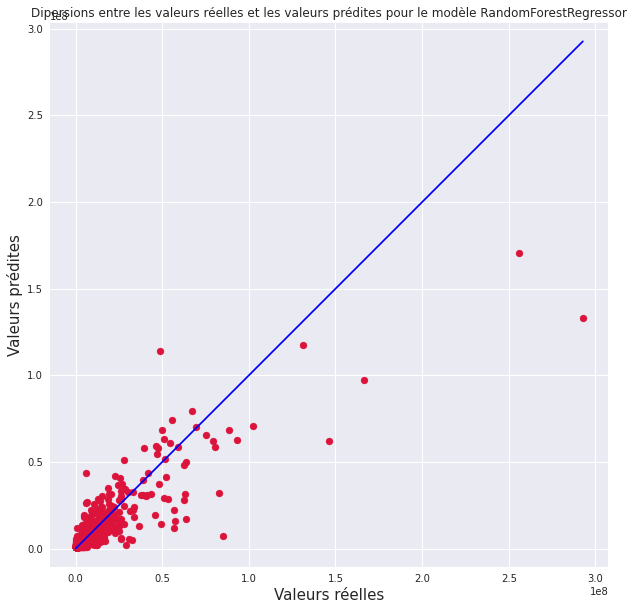

CPU times: user 1min 6s, sys: 0 ns, total: 1min 6s
Wall time: 1min 6s


TransformedTargetRegressor(regressor=RandomForestRegressor(max_depth=8,
                                                           n_estimators=1400,
                                                           random_state=42),
                           transformer=Pipeline(steps=[('Robust',
                                                        RobustScaler()),
                                                       ('MinMax',
                                                        MinMaxScaler())]))

In [35]:
%%time
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=42, bootstrap=True, max_features='auto', max_depth = 8,  min_samples_leaf=1, min_samples_split=2, n_estimators = 1400)
train_evaluate_model(rf, X_co2_train_transformed, y_energy_train)

#### Récapitulatif des score

In [246]:
scores = {
            "wo_estar" : [74.6, 71.4],
            "w_estar" :[75, 74.4],
            "delta" : [0.7, 0.7]
         }
df_scores = pd.DataFrame(scores, columns=["wo_estar", "w_estar", "delta"], index=["Energie", "CO2"])
df_scores

,wo_estar,w_estar,delta
Energie,74.6,75.0,0.7
CO2,71.4,74.4,0.7


### Gradient Boosting pour la prédiction de consommation d'énergie sans "ENERGYSTARScore"

Pour le modèle GradientBoostingRegressor
Meilleurs hyper paramètres {'regressor__learning_rate': 0.1, 'regressor__max_depth': 4, 'regressor__n_estimators': 200}
R2 sur le jeu d'entraînement 0.987
Le R2 moyen de la cross validation est de 0.804 (+/-0.008)


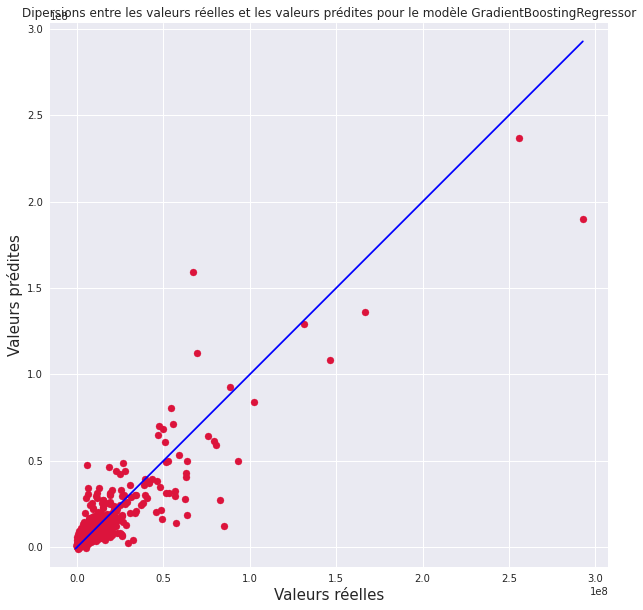

CPU times: user 7.74 s, sys: 597 ms, total: 8.33 s
Wall time: 26min 50s


TransformedTargetRegressor(regressor=GradientBoostingRegressor(max_depth=4,
                                                               n_estimators=200),
                           transformer=Pipeline(steps=[('Robust',
                                                        RobustScaler()),
                                                       ('MinMax',
                                                        MinMaxScaler())]))

In [20]:
%%time
from sklearn.ensemble import GradientBoostingRegressor
params_grid = {'regressor__max_depth': [1,2,3,4,5,6,None],
               'regressor__learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
               'regressor__n_estimators' : [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
gb =  GradientBoostingRegressor()
train_evaluate_model(gb, X_energy_train_transformed_wo_estar, y_energy_train,params=params_grid)

### Gradient Boosting pour la prédiction de consommation d'énergie avec "ENERGYSTARScore"

Pour le modèle GradientBoostingRegressor
R2 sur le jeu d'entraînement: 0.991
Le R2 moyen de la cross validation est de 0.778 (+/-0.095)


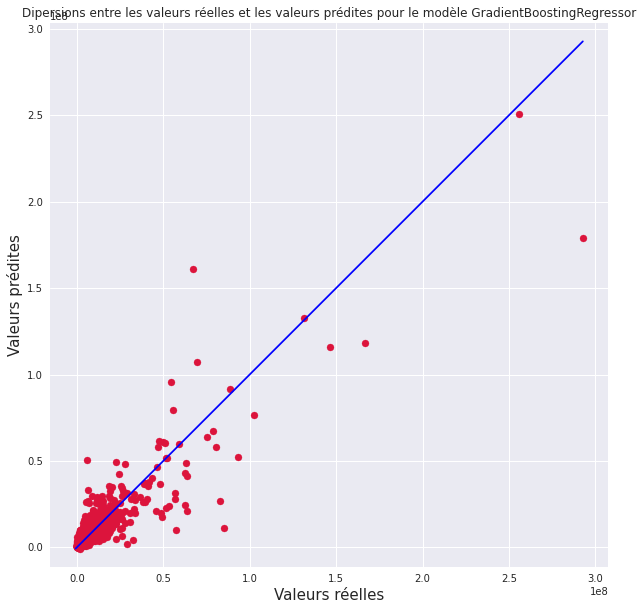

CPU times: user 7.22 s, sys: 0 ns, total: 7.22 s
Wall time: 7.22 s


TransformedTargetRegressor(regressor=GradientBoostingRegressor(max_depth=4,
                                                               n_estimators=200),
                           transformer=Pipeline(steps=[('Robust',
                                                        RobustScaler()),
                                                       ('MinMax',
                                                        MinMaxScaler())]))

In [36]:
%%time
from sklearn.ensemble import GradientBoostingRegressor
gb =  GradientBoostingRegressor(learning_rate = 0.1, max_depth = 4, n_estimators = 200)
train_evaluate_model(gb, X_energy_train_transformed, y_energy_train)

### Gradient Boosting pour la prédiction d'émission de CO2 sans "ENERGYSTARScore"

Pour le modèle GradientBoostingRegressor
Meilleurs hyper paramètres {'regressor__learning_rate': 0.2, 'regressor__max_depth': 3, 'regressor__n_estimators': 1400}
R2 sur le jeu d'entraînement 1.000
Le R2 moyen de la cross validation est de 0.547 (+/-0.019)


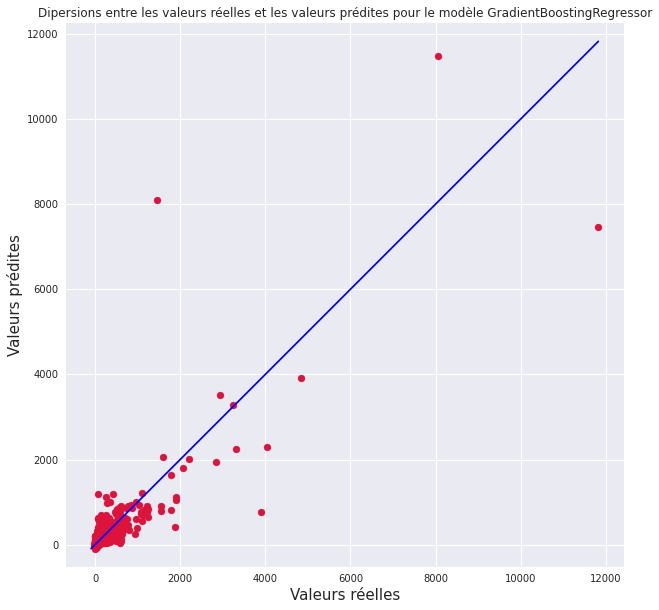

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 2.62 µs
CPU times: user 26.5 s, sys: 352 ms, total: 26.8 s
Wall time: 27min 18s


In [21]:
%%time
from sklearn.ensemble import GradientBoostingRegressor
params_grid = {'regressor__max_depth': [1,2,3,4,5,6,None],
               'regressor__learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
               'regressor__n_estimators' : [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
gb =  GradientBoostingRegressor()
train_evaluate_model(gb, X_co2_train_transformed_wo_estar, y_co2_train,params=params_grid)
%time

### Gradient Boosting pour la prédiction d'émission de CO2 avec "ENERGYSTARScore"

Pour le modèle GradientBoostingRegressor
R2 sur le jeu d'entraînement: 1.000
Le R2 moyen de la cross validation est de 0.771 (+/-0.112)


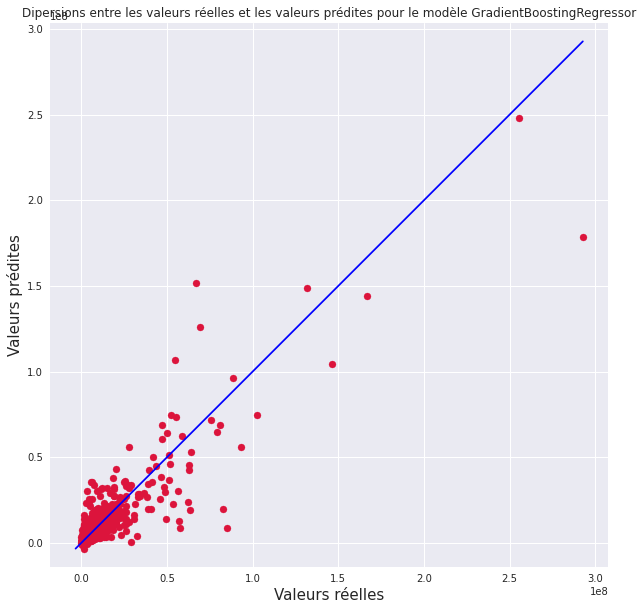

CPU times: user 37.4 s, sys: 0 ns, total: 37.4 s
Wall time: 37.4 s


TransformedTargetRegressor(regressor=GradientBoostingRegressor(learning_rate=0.2,
                                                               n_estimators=1400),
                           transformer=Pipeline(steps=[('Robust',
                                                        RobustScaler()),
                                                       ('MinMax',
                                                        MinMaxScaler())]))

In [37]:
%%time
from sklearn.ensemble import GradientBoostingRegressor
gb =  GradientBoostingRegressor(learning_rate = 0.2, max_depth = 3, n_estimators = 1400)
train_evaluate_model(gb, X_co2_train_transformed, y_energy_train)

#### Récapitulatif des scores

In [209]:
scores = {
            "wo_estar" : [80.4, 54.7],
            "w_estar" :[77.8, 77.1],
            "delta" : [0.4, -3.0]
         }
df_scores = pd.DataFrame(scores, columns=["wo_estar", "w_estar", "delta"], index=["Energie", "CO2"])
df_scores

,wo_estar,w_estar,delta
Energie,80.4,77.8,0.4
CO2,54.7,77.1,-3.0


## Evaluation sur le jeu de test des modèles

En sortie de phase d'entrainement et de sélection d'hyperparamètres. Le modèle le plus performant pour la prédiction d'énergy est le gradient boosting alors que pour la prédiction de CO2 il s'agit de la random forest. Vu la performance du gradient boosting en dessous de la regression linéraire simple, nous préférons garder tous les modèles, exceptés les SVM à noyeau pour tester la généralisation des modèles.

Par contre nous réalisons cette phase d'évaluation uniquement sans la vériable ENERGYSTARScore. Cette dernière n'a offert qu'un gain faible de performance sur tous les modèles qui ont fonctionné.

### Regression linaire non pénalisée pour la prédiction de consommation d'énergie

Pour le modèle TransformedTargetRegressor
R2 sur le jeu de test: 0.542


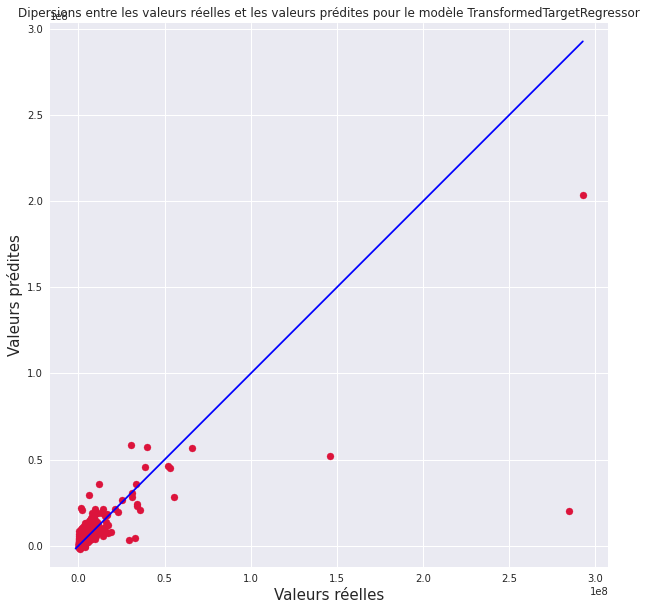

CPU times: user 387 ms, sys: 950 ms, total: 1.34 s
Wall time: 169 ms


In [190]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression(fit_intercept=True)
transformer = Pipeline(steps=[
                              ('Robust', RobustScaler()),
                              ('MinMax', MinMaxScaler())
                             ]
                      )
model = TransformedTargetRegressor(regressor=lr, transformer=transformer)
model.fit(X=X_energy_train_transformed_wo_estar, y=y_energy_train)
y_pred_test = model.predict(X=X_energy_test_transformed_wo_estar)
r2 =  r2_score(y_true= y_energy_test, y_pred=y_pred_test)
print(f"Pour le modèle {type(model).__name__}")
print(f"R2 sur le jeu de test: {r2:.3f}")

plt.figure(figsize=(10,10))
plt.scatter(y_energy_test, y_pred_test, c='crimson')
p1 = max(max(y_pred_test), max(y_energy_test))
p2 = min(min(y_pred_test), min(y_energy_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Valeurs réelles', fontsize=15)
plt.ylabel('Valeurs prédites', fontsize=15)
plt.axis('equal')
plt.title(f"Dipersions entre les valeurs réelles et les valeurs prédites pour le modèle {type(model).__name__}")
plt.show()

#### Regression linaire non pénalisée pour prédicion de consommation de Co2

Pour le modèle TransformedTargetRegressor
R2 sur le jeu de test: 0.667


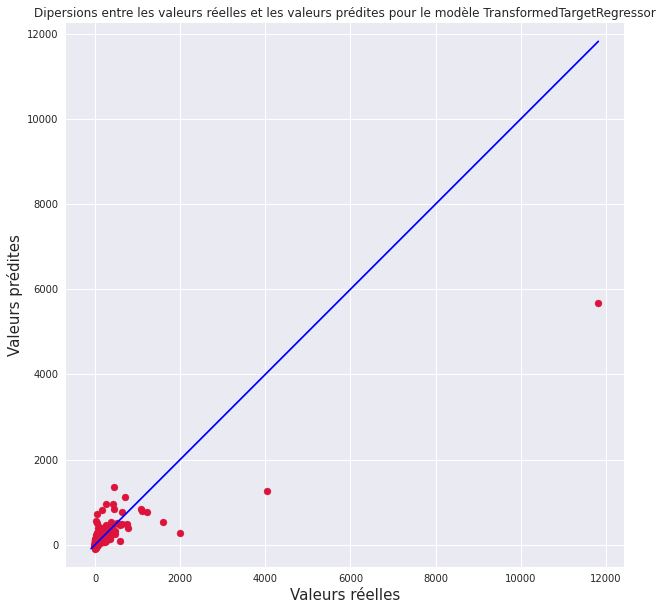

CPU times: user 440 ms, sys: 851 ms, total: 1.29 s
Wall time: 137 ms


In [195]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression(fit_intercept=True)
transformer = Pipeline(steps=[
                              ('Robust', RobustScaler()),
                              ('MinMax', MinMaxScaler())
                             ]
                      )
model = TransformedTargetRegressor(regressor=lr, transformer=transformer)
model.fit(X=X_co2_train_transformed_wo_estar, y=y_co2_train)
y_pred_test = model.predict(X=X_co2_test_transformed_wo_estar)
r2 =  r2_score(y_true= y_co2_test, y_pred=y_pred_test)
print(f"Pour le modèle {type(model).__name__}")
print(f"R2 sur le jeu de test: {r2:.3f}")

plt.figure(figsize=(10,10))
plt.scatter(y_co2_test, y_pred_test, c='crimson')
p1 = max(max(y_pred_test), max(y_co2_test))
p2 = min(min(y_pred_test), min(y_co2_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Valeurs réelles', fontsize=15)
plt.ylabel('Valeurs prédites', fontsize=15)
plt.axis('equal')
plt.title(f"Dipersions entre les valeurs réelles et les valeurs prédites pour le modèle {type(model).__name__}")
plt.show()

### Comparatif cross validation vs test

In [247]:
scores = {
            "cross validation" : [57.0, 57.0],
            "test" :[54.2, 66.7],
         }
df_scores = pd.DataFrame(scores, columns=["cross validation", "test"], index=["Energie", "CO2"])
df_scores

,cross validation,test
Energie,57.0,54.2
CO2,57.0,66.7


### Regression Ridge pour la prédiction de consommation d'énergie

Pour le modèle TransformedTargetRegressor
R2 sur le jeu de test: 0.479


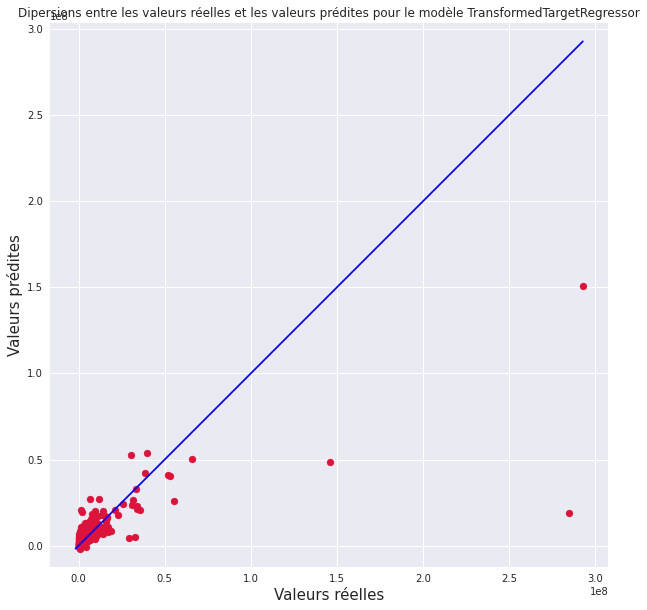

CPU times: user 315 ms, sys: 921 ms, total: 1.24 s
Wall time: 156 ms


In [196]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


from sklearn.linear_model import Ridge 

lr_ridge = Ridge(random_state=42, alpha =1.499268432786047)

transformer = Pipeline(steps=[
                              ('Robust', RobustScaler()),
                              ('MinMax', MinMaxScaler())
                             ]
                      )
model = TransformedTargetRegressor(regressor=lr_ridge, transformer=transformer)
model.fit(X=X_energy_train_transformed_wo_estar, y=y_energy_train)
y_pred_test = model.predict(X=X_energy_test_transformed_wo_estar)
r2 =  r2_score(y_true= y_energy_test, y_pred=y_pred_test)
print(f"Pour le modèle {type(model).__name__}")
print(f"R2 sur le jeu de test: {r2:.3f}")

plt.figure(figsize=(10,10))
plt.scatter(y_energy_test, y_pred_test, c='crimson')
p1 = max(max(y_pred_test), max(y_energy_test))
p2 = min(min(y_pred_test), min(y_energy_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Valeurs réelles', fontsize=15)
plt.ylabel('Valeurs prédites', fontsize=15)
plt.axis('equal')
plt.title(f"Dipersions entre les valeurs réelles et les valeurs prédites pour le modèle {type(model).__name__}")
plt.show()

### Regression Ridge pour la prédiction d'émissions de CO2

Pour le modèle TransformedTargetRegressor
R2 sur le jeu de test: 0.446


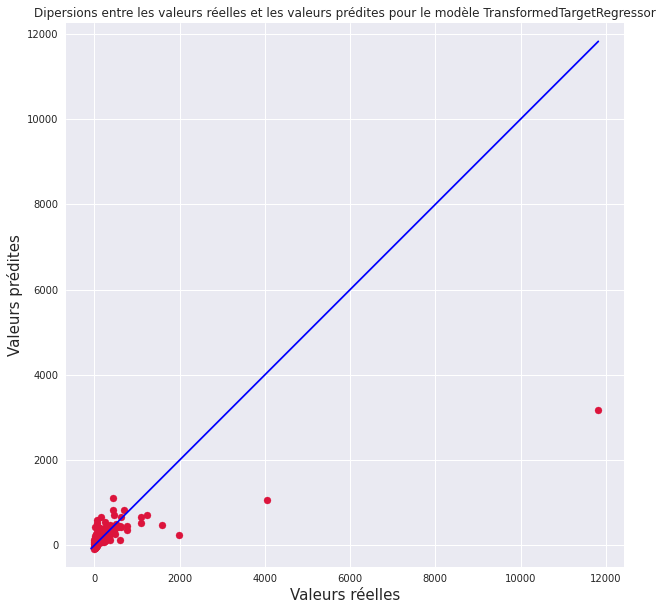

CPU times: user 261 ms, sys: 1.01 s, total: 1.27 s
Wall time: 134 ms


In [194]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


from sklearn.linear_model import Ridge 

lr_ridge = Ridge(random_state=42, alpha=3.3700643292719317)

transformer = Pipeline(steps=[
                              ('Robust', RobustScaler()),
                              ('MinMax', MinMaxScaler())
                             ]
                      )
model = TransformedTargetRegressor(regressor=lr_ridge, transformer=transformer)
model.fit(X=X_co2_train_transformed_wo_estar, y=y_co2_train)
y_pred_test = model.predict(X=X_co2_test_transformed_wo_estar)
r2 =  r2_score(y_true= y_co2_test, y_pred=y_pred_test)
print(f"Pour le modèle {type(model).__name__}")
print(f"R2 sur le jeu de test: {r2:.3f}")

plt.figure(figsize=(10,10))
plt.scatter(y_co2_test, y_pred_test, c='crimson')
p1 = max(max(y_pred_test), max(y_co2_test))
p2 = min(min(y_pred_test), min(y_co2_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Valeurs réelles', fontsize=15)
plt.ylabel('Valeurs prédites', fontsize=15)
plt.axis('equal')
plt.title(f"Dipersions entre les valeurs réelles et les valeurs prédites pour le modèle {type(model).__name__}")
plt.show()

### Comparatif cross validation vs test

In [238]:
scores = {
            "cross validation" : [61.2, 42.2],
            "test" :[47.9, 44.6],
         }
df_scores = pd.DataFrame(scores, columns=["cross validation", "test"], index=["Energie", "CO2"])
df_scores

,cross validation,test
Energie,61.2,47.9
CO2,42.2,44.6


### Regression Lasso pour la prédiction de consommation d'énergie

Pour le modèle TransformedTargetRegressor
R2 sur le jeu de test: 0.412


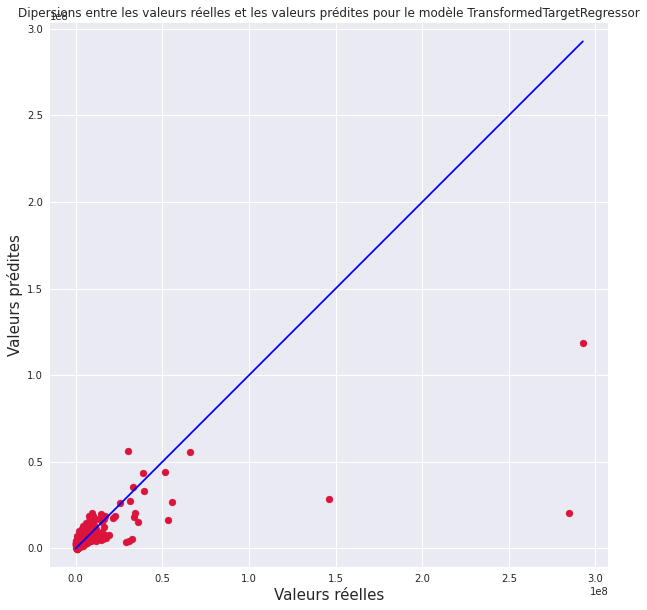

CPU times: user 340 ms, sys: 1.08 s, total: 1.42 s
Wall time: 147 ms


In [197]:
%%time

from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

lr_lasso = Lasso(random_state=42, alpha = 0.0003107866187782014)

transformer = Pipeline(steps=[
                              ('Robust', RobustScaler()),
                              ('MinMax', MinMaxScaler())
                             ]
                      )
model = TransformedTargetRegressor(regressor=lr_lasso, transformer=transformer)
model.fit(X=X_energy_train_transformed_wo_estar, y=y_energy_train)
y_pred_test = model.predict(X=X_energy_test_transformed_wo_estar)
r2 =  r2_score(y_true= y_energy_test, y_pred=y_pred_test)
print(f"Pour le modèle {type(model).__name__}")
print(f"R2 sur le jeu de test: {r2:.3f}")

plt.figure(figsize=(10,10))
plt.scatter(y_energy_test, y_pred_test, c='crimson')
p1 = max(max(y_pred_test), max(y_energy_test))
p2 = min(min(y_pred_test), min(y_energy_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Valeurs réelles', fontsize=15)
plt.ylabel('Valeurs prédites', fontsize=15)
plt.axis('equal')
plt.title(f"Dipersions entre les valeurs réelles et les valeurs prédites pour le modèle {type(model).__name__}")
plt.show()

### Regression Lasso pour la prédiction d'émission de CO2

Pour le modèle TransformedTargetRegressor
R2 sur le jeu de test: 0.376


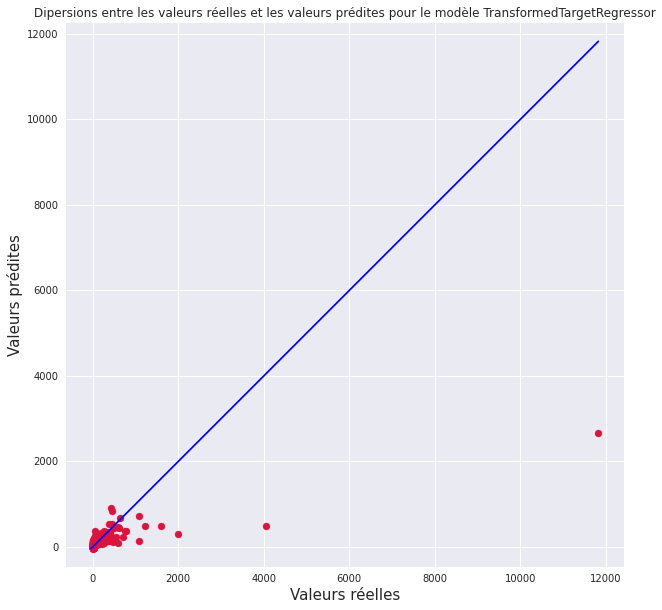

CPU times: user 505 ms, sys: 999 ms, total: 1.5 s
Wall time: 156 ms


In [198]:
%%time

from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

lr_lasso = Lasso(random_state=42, alpha = 0.00035297073027306503)

transformer = Pipeline(steps=[
                              ('Robust', RobustScaler()),
                              ('MinMax', MinMaxScaler())
                             ]
                      )
model = TransformedTargetRegressor(regressor=lr_lasso, transformer=transformer)
model.fit(X=X_co2_train_transformed_wo_estar, y=y_co2_train)
y_pred_test = model.predict(X=X_co2_test_transformed_wo_estar)
r2 =  r2_score(y_true= y_co2_test, y_pred=y_pred_test)
print(f"Pour le modèle {type(model).__name__}")
print(f"R2 sur le jeu de test: {r2:.3f}")

plt.figure(figsize=(10,10))
plt.scatter(y_co2_test, y_pred_test, c='crimson')
p1 = max(max(y_pred_test), max(y_co2_test))
p2 = min(min(y_pred_test), min(y_co2_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Valeurs réelles', fontsize=15)
plt.ylabel('Valeurs prédites', fontsize=15)
plt.axis('equal')
plt.title(f"Dipersions entre les valeurs réelles et les valeurs prédites pour le modèle {type(model).__name__}")
plt.show()

### Comparatif cross validation vs test

In [248]:
scores = {
            "cross validation" : [57.7, 37.6],
            "test" :[41.2, 37.6],
         }
df_scores = pd.DataFrame(scores, columns=["cross validation", "test"], index=["Energie", "CO2"])
df_scores

,cross validation,test
Energie,57.7,41.2
CO2,37.6,37.6


### SVM Linéaire pour la prédiction d'énergie

Pour le modèle TransformedTargetRegressor
R2 sur le jeu de test: 0.390


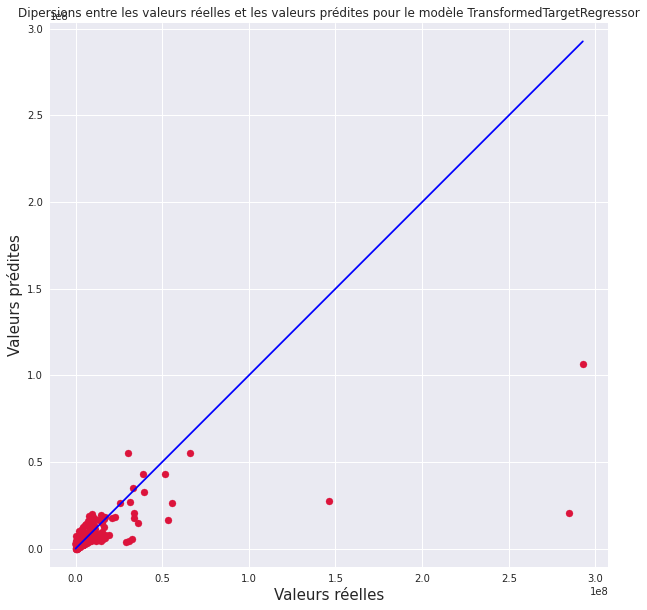

CPU times: user 413 ms, sys: 1.06 s, total: 1.48 s
Wall time: 152 ms


In [199]:
%%time

from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score

lin_svr = LinearSVR(dual=False, loss='squared_epsilon_insensitive', C=0.46415888336127775, random_state=42)

transformer = Pipeline(steps=[
                              ('Robust', RobustScaler()),
                              ('MinMax', MinMaxScaler())
                             ]
                      )
model = TransformedTargetRegressor(regressor=lr_lasso, transformer=transformer)
model.fit(X=X_energy_train_transformed_wo_estar, y=y_energy_train)
y_pred_test = model.predict(X=X_energy_test_transformed_wo_estar)
r2 =  r2_score(y_true= y_energy_test, y_pred=y_pred_test)
print(f"Pour le modèle {type(model).__name__}")
print(f"R2 sur le jeu de test: {r2:.3f}")

plt.figure(figsize=(10,10))
plt.scatter(y_energy_test, y_pred_test, c='crimson')
p1 = max(max(y_pred_test), max(y_energy_test))
p2 = min(min(y_pred_test), min(y_energy_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Valeurs réelles', fontsize=15)
plt.ylabel('Valeurs prédites', fontsize=15)
plt.axis('equal')
plt.title(f"Dipersions entre les valeurs réelles et les valeurs prédites pour le modèle {type(model).__name__}")
plt.show()

### SVM Linéaire pour la prédiction d'émission de CO2

Pour le modèle TransformedTargetRegressor
R2 sur le jeu de test: 0.376


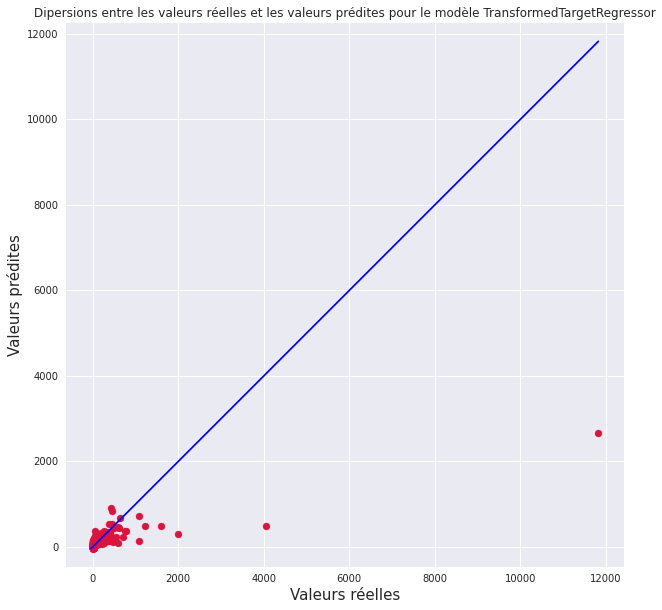

CPU times: user 333 ms, sys: 991 ms, total: 1.32 s
Wall time: 152 ms


In [200]:
%%time

from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score

lin_svr = LinearSVR(dual=False, loss='squared_epsilon_insensitive', C=0.46415888336127775, random_state=42)

transformer = Pipeline(steps=[
                              ('Robust', RobustScaler()),
                              ('MinMax', MinMaxScaler())
                             ]
                      )
model = TransformedTargetRegressor(regressor=lr_lasso, transformer=transformer)
model.fit(X=X_co2_train_transformed_wo_estar, y=y_co2_train)
y_pred_test = model.predict(X=X_co2_test_transformed_wo_estar)
r2 =  r2_score(y_true= y_co2_test, y_pred=y_pred_test)
print(f"Pour le modèle {type(model).__name__}")
print(f"R2 sur le jeu de test: {r2:.3f}")

plt.figure(figsize=(10,10))
plt.scatter(y_co2_test, y_pred_test, c='crimson')
p1 = max(max(y_pred_test), max(y_co2_test))
p2 = min(min(y_pred_test), min(y_co2_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Valeurs réelles', fontsize=15)
plt.ylabel('Valeurs prédites', fontsize=15)
plt.axis('equal')
plt.title(f"Dipersions entre les valeurs réelles et les valeurs prédites pour le modèle {type(model).__name__}")
plt.show()

#### Comparatif cross validation vs test 

In [249]:
scores = {
            "cross validation" : [61.1, 41.8],
            "test" :[39.0, 37.6],
         }
df_scores = pd.DataFrame(scores, columns=["cross validation", "test"], index=["Energie", "CO2"])
df_scores

,cross validation,test
Energie,61.1,39.0
CO2,41.8,37.6


### Evaluation de la Random Forest pour la consommation d'énergie

Pour le modèle TransformedTargetRegressor
R2 sur le jeu de test: 0.502


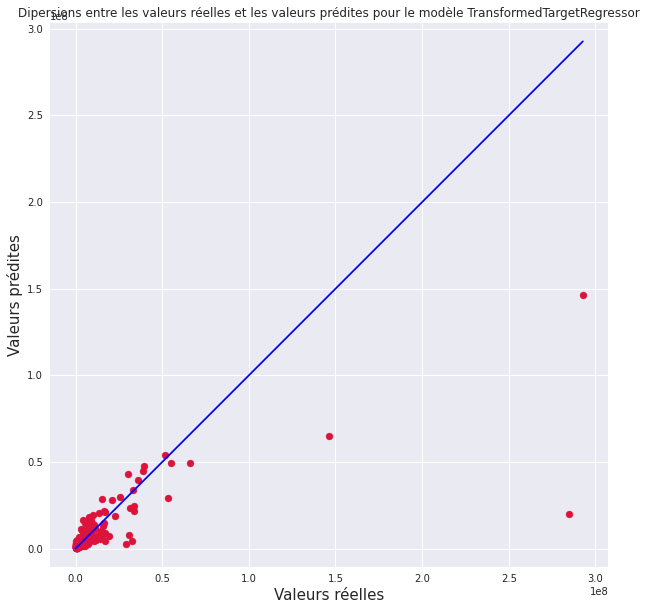

CPU times: user 9.14 s, sys: 0 ns, total: 9.14 s
Wall time: 9.13 s


In [211]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
rf = RandomForestRegressor(random_state=42, bootstrap=True, max_features='auto', max_depth = 12,  min_samples_leaf=1, min_samples_split=2, n_estimators = 1400)
transformer = Pipeline(steps=[
                              ('Robust', RobustScaler()),
                              ('MinMax', MinMaxScaler())
                             ]
                      )
model = TransformedTargetRegressor(regressor=rf, transformer=transformer)
model.fit(X=X_energy_train_transformed_wo_estar, y=y_energy_train)
y_pred_test = model.predict(X=X_energy_test_transformed_wo_estar)
r2 =  r2_score(y_true= y_energy_test, y_pred=y_pred_test)
print(f"Pour le modèle {type(model).__name__}")
print(f"R2 sur le jeu de test: {r2:.3f}")

plt.figure(figsize=(10,10))
plt.scatter(y_energy_test, y_pred_test, c='crimson')
p1 = max(max(y_pred_test), max(y_energy_test))
p2 = min(min(y_pred_test), min(y_energy_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Valeurs réelles', fontsize=15)
plt.ylabel('Valeurs prédites', fontsize=15)
plt.axis('equal')
plt.title(f"Dipersions entre les valeurs réelles et les valeurs prédites pour le modèle {type(model).__name__}")
plt.show()

### Evaluation de la Random Forest pour les émissions de Co2

Pour le modèle TransformedTargetRegressor
R2 sur le jeu de test: 0.474


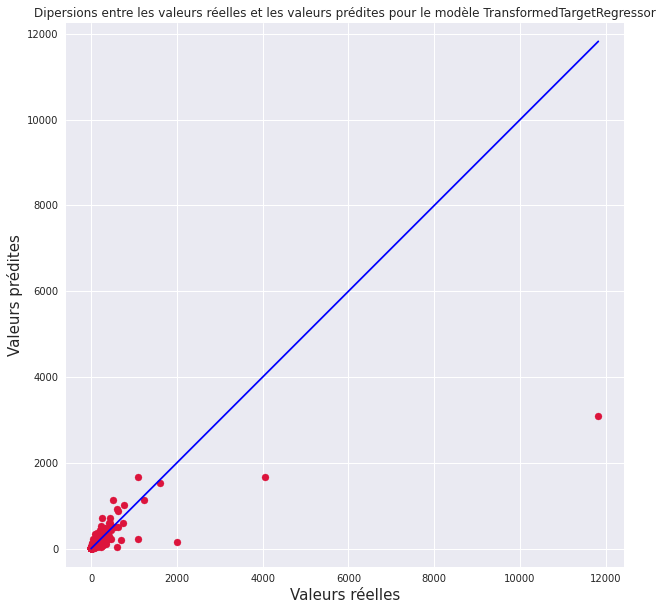

CPU times: user 7.91 s, sys: 0 ns, total: 7.91 s
Wall time: 7.9 s


In [213]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
rf = RandomForestRegressor(random_state=42, bootstrap=True, max_features='auto', max_depth = 11,  min_samples_leaf=4, min_samples_split=2, n_estimators = 1400)
transformer = Pipeline(steps=[
                              ('Robust', RobustScaler()),
                              ('MinMax', MinMaxScaler())
                             ]
                      )
model = TransformedTargetRegressor(regressor=rf, transformer=transformer)
model.fit(X=X_co2_train_transformed_wo_estar, y=y_co2_train)
y_pred_test = model.predict(X=X_co2_test_transformed_wo_estar)
r2 =  r2_score(y_true= y_co2_test, y_pred=y_pred_test)
print(f"Pour le modèle {type(model).__name__}")
print(f"R2 sur le jeu de test: {r2:.3f}")

plt.figure(figsize=(10,10))
plt.scatter(y_co2_test, y_pred_test, c='crimson')
p1 = max(max(y_pred_test), max(y_co2_test))
p2 = min(min(y_pred_test), min(y_co2_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Valeurs réelles', fontsize=15)
plt.ylabel('Valeurs prédites', fontsize=15)
plt.axis('equal')
plt.title(f"Dipersions entre les valeurs réelles et les valeurs prédites pour le modèle {type(model).__name__}")
plt.show()

#### Comparatif cross validation vs test 

In [232]:
scores = {
            "cross validation" : [61.1, 39.0],
            "test" :[50.2, 47.4],
         }
df_scores = pd.DataFrame(scores, columns=["cross validation", "test"], index=["Energie", "CO2"])
df_scores

,cross validation,test
Energie,74.6,50.2
CO2,74.6,47.4


### Evaluation de le gradient boosting pour la consommation d'énergie

Pour le modèle TransformedTargetRegressor
R2 sur le jeu de test: 0.572


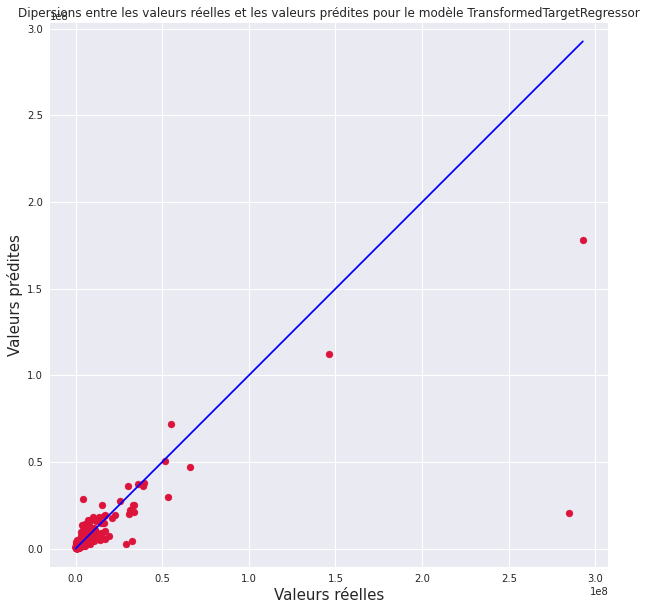

CPU times: user 821 ms, sys: 0 ns, total: 821 ms
Wall time: 818 ms


In [212]:
%%time
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
gb =  GradientBoostingRegressor(learning_rate = 0.1, max_depth = 4, n_estimators = 200)
transformer = Pipeline(steps=[
                              ('Robust', RobustScaler()),
                              ('MinMax', MinMaxScaler())
                             ]
                      )
model = TransformedTargetRegressor(regressor=gb, transformer=transformer)
model.fit(X=X_energy_train_transformed_wo_estar, y=y_energy_train)
y_pred_test = model.predict(X=X_energy_test_transformed_wo_estar)
r2 =  r2_score(y_true= y_energy_test, y_pred=y_pred_test)
print(f"Pour le modèle {type(model).__name__}")
print(f"R2 sur le jeu de test: {r2:.3f}")

plt.figure(figsize=(10,10))
plt.scatter(y_energy_test, y_pred_test, c='crimson')
p1 = max(max(y_pred_test), max(y_energy_test))
p2 = min(min(y_pred_test), min(y_energy_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Valeurs réelles', fontsize=15)
plt.ylabel('Valeurs prédites', fontsize=15)
plt.axis('equal')
plt.title(f"Dipersions entre les valeurs réelles et les valeurs prédites pour le modèle {type(model).__name__}")
plt.show()

### Evaluation de le gradient boosting pour les élissions de CO2

Pour le modèle TransformedTargetRegressor
R2 sur le jeu de test: 0.780


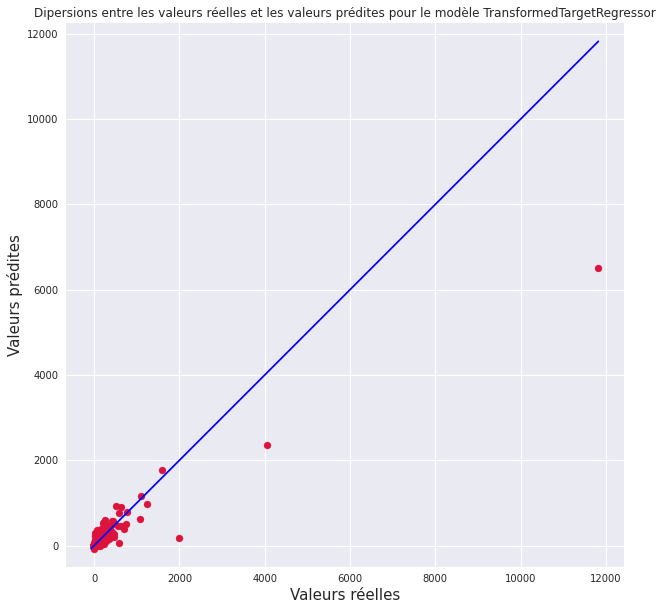

CPU times: user 3.9 s, sys: 0 ns, total: 3.9 s
Wall time: 3.89 s


In [214]:
%%time
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
gb =  GradientBoostingRegressor(learning_rate = 0.2, max_depth = 3, n_estimators = 1400)
transformer = Pipeline(steps=[
                              ('Robust', RobustScaler()),
                              ('MinMax', MinMaxScaler())
                             ]
                      )
model = TransformedTargetRegressor(regressor=gb, transformer=transformer)
model.fit(X=X_co2_train_transformed_wo_estar, y=y_co2_train)
y_pred_test = model.predict(X=X_co2_test_transformed_wo_estar)
r2 =  r2_score(y_true= y_co2_test, y_pred=y_pred_test)
print(f"Pour le modèle {type(model).__name__}")
print(f"R2 sur le jeu de test: {r2:.3f}")

plt.figure(figsize=(10,10))
plt.scatter(y_co2_test, y_pred_test, c='crimson')
p1 = max(max(y_pred_test), max(y_co2_test))
p2 = min(min(y_pred_test), min(y_co2_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Valeurs réelles', fontsize=15)
plt.ylabel('Valeurs prédites', fontsize=15)
plt.axis('equal')
plt.title(f"Dipersions entre les valeurs réelles et les valeurs prédites pour le modèle {type(model).__name__}")
plt.show()

#### Comparatif cross validation vs test

In [229]:
scores = {
            "cross validation" : [80.4, 57.2],
            "test" :[57.2, 78.0],
         }
df_scores = pd.DataFrame(scores, columns=["cross validation", "test"], index=["Energie", "CO2"])
df_scores

,cross validation,test
Energie,80.4,57.2
CO2,57.2,78.0


A l'issu de l'évaluation des modèles, il s'avère que les modèles de Gradient Boosting offrent, pour les deux variables à prédire, de meilleures performances sur le jeu de test pour l'année 2015. Attention toutefois, les performance sont moins bonnes pour la prédiction des émissions de CO2 sur le jeu de test. Il se pourrait que le modèle souffre de problème de sous-apprentissage. 

## Test des modèles sur l'année 2016

Nous testons enfin les deux modèles sur l'année 2016. Nous gradons les hyper paramètres mais réentrainons les modèles avec les données de l'année.

### Préprocesseing

Nous reprenons l'ensemnle des cellules qui ont servi le préprocessing de l'année 2015. A l'avenir, les futurs jeuex de données, nettoyés au préalable, pourront être préparé à l'aide de la cellule suivante.  

In [219]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split

def preprocessing_data(X_train, X_test, no_transformation_cols, to_scale_cols, to_scale_and_log_cols):
    """
    Preprocess data in order to train machine learning models
    
    Args:
        X_train(DataFrame): Train set input variables to preprocess
        
        X_test(DataFrame): Test set input variables to preprocess 
        
        no_transformation_cols(list): List of variables that will not be transformed
        
        to_standardise_cols(list): List of variables to be standardised
        
        to_log_cols(list): List of variables to be log scaled
    
    Returns:
        X_train_preprocessed(DataFrame): Preprocessed train set 
        
        X_test_transformed(DataFRame): Preprocessed test set
    """

    X_train_no_transformation = pd.DataFrame(X_train.loc[:,no_transformation_cols], columns=no_transformation_cols)
    X_test_no_transformation = pd.DataFrame(X_test.loc[:,no_transformation_cols], columns=no_transformation_cols)
    
    
    scaler = Pipeline(steps=[
                              ('Robust', RobustScaler()),
                              ('MinMax', MinMaxScaler())
                             ]
                      )
    
    scaler.fit(X_train.loc[:,to_scale_cols])
    X_train_to_scale = pd.DataFrame(scaler.transform(X_train.loc[:,to_scale_cols]), columns=to_scale_cols, index=X_energy_train.index)
    X_test_to_scale =  pd.DataFrame(scaler.transform(X_test.loc[:,to_scale_cols]), columns=to_scale_cols, index=X_energy_test.index)
    
    #transformer = Pipeline(steps=[
                                  #('log', FunctionTransformer(func=np.log1p, inverse_func=np.expm1)),
                                  #('Robust', RobustScaler()),
                                  #('MinMax', MinMaxScaler())
                                 #]
                          #)
    
    #transformer.fit(X_train.loc[:,to_scale_and_log_cols])
    #X_train_to_scale_and_log = pd.DataFrame(transformer.transform(X_train.loc[:,to_scale_and_log_cols]), columns=to_scale_and_log_cols, index=X_energy_train.index)
    #X_test_to_scale_and_log =  pd.DataFrame(transformer.transform(X_test.loc[:,to_scale_and_log_cols]), columns=to_scale_and_log_cols, index=X_energy_test.index)
    

    X_train_transformed = pd.concat([X_train_no_transformation, X_train_to_scale] ,  axis=1)
    X_test_transformed = pd.concat([X_test_no_transformation, X_test_to_scale], axis=1)
    
    return X_train_transformed, X_test_transformed

data_2016 = pd.read_csv("data_2016.csv", index_col="OSEBuildingID")


kbins = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='uniform')
data_2016["discretized_GFATotal"] = kbins.fit_transform(data_201["PropertyGFATotal"].values.reshape(-1,1))
reordered_cols = ['YearBuilt', 
                 'PropertyGFATotal', 
                 'discretized_GFATotal', 
                 'GFA_by_floor', 
                 'more_one_building',
                 'PropertyUseTypes', 
                 'Multifamily Housing_prop',
                 'Non-Refrigerated Warehouse_prop',
                 'Worship Facility_prop',
                 'Self-Storage Facility_prop', 
                 'Distribution Center_prop',
                 'K-12 School_prop', 
                 'Supermarket/Grocery Store_prop', 
                 'Hotel_prop',
                 'Other_prop', 
                 'Parking_prop',
                 'Hospital (General Medical & Surgical)_prop', 
                 'Laboratory_prop',
                 'Restaurant_prop', 
                 'Automobile Dealership_prop', 
                 'Office_prop',
                 'Electricity(kBtu)_prop', 
                 'NaturalGas(kBtu)_prop',
                 'SteamUse(kBtu)_prop', 
                 'ENERGYSTARScore', 
                 'SiteEnergyUseWN(kBtu)',
                 'GHGEmissions(MetricTonsCO2e)']
data_2016 = data_2016[reordered_cols]

 

X_energy = data_2016.iloc[:,:-2].copy()
X_co2 = data_2016.iloc[:,:-2].copy()
y_energy = data_2016["SiteEnergyUseWN(kBtu)"].copy()
y_co2 = data_2016["GHGEmissions(MetricTonsCO2e)"].copy()

X_energy_train, X_energy_test, y_energy_train, y_energy_test = train_test_split(X_energy,y_energy, test_size=0.2, stratify=X_energy["discretized_GFATotal"] , random_state=42)
X_co2_train, X_co2_test, y_co2_train, y_co2_test = train_test_split(X_co2,y_co2, test_size=0.2, stratify=X_co2["discretized_GFATotal"] , random_state=42)

data_2016.drop(columns="discretized_GFATotal", inplace=True)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer

no_transformation_cols = [
                          "more_one_building"
                        ]

to_scale_cols = [
                 "PropertyGFATotal",
                 "GFA_by_floor",
                 "PropertyUseTypes",
                 "YearBuilt",
                 "ENERGYSTARScore",
                 "Multifamily Housing_prop",
                 "Non-Refrigerated Warehouse_prop",
                 "Worship Facility_prop",
                 "Self-Storage Facility_prop",
                 "Distribution Center_prop",
                 "K-12 School_prop",
                 "Supermarket/Grocery Store_prop" ,
                 "Hotel_prop",
                 "Other_prop",
                 "Parking_prop",
                 "Hospital (General Medical & Surgical)_prop" ,
                 "Laboratory_prop",
                 "Restaurant_prop",
                 "Automobile Dealership_prop",
                 "Office_prop",
                 "SteamUse(kBtu)_prop",
                 "Electricity(kBtu)_prop",
                 "NaturalGas(kBtu)_prop", 
                ]

X_energy_train_transformed , X_energy_test_transformed = preprocessing_data(X_energy_train, X_energy_test, no_transformation_cols, to_scale_cols, to_scale_and_log_cols)
X_co2_train_transformed, X_co2_test_transformed = preprocessing_data(X_co2_train, X_co2_test, no_transformation_cols, to_scale_cols, to_scale_and_log_cols)

X_energy_train_transformed_wo_estar = X_energy_train_transformed.drop(columns="ENERGYSTARScore")
X_energy_test_transformed_wo_estar = X_energy_test_transformed.drop(columns="ENERGYSTARScore")
X_co2_train_transformed_wo_estar = X_co2_train_transformed.drop(columns="ENERGYSTARScore")
X_co2_test_transformed_wo_estar = X_co2_test_transformed.drop(columns="ENERGYSTARScore")

### Prédiction de la consommation d'énergie

Pour le modèle TransformedTargetRegressor
R2 sur le jeu de test: 0.779


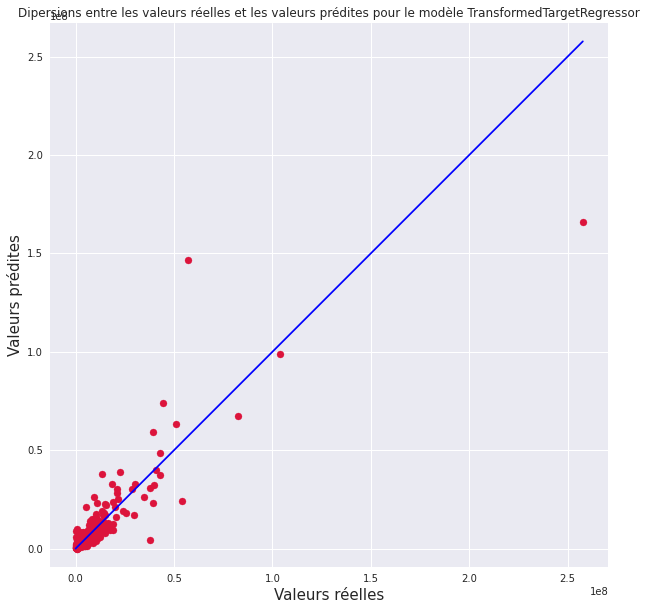

CPU times: user 842 ms, sys: 0 ns, total: 842 ms
Wall time: 839 ms


In [223]:
%%time
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
gb =  GradientBoostingRegressor(learning_rate = 0.1, max_depth = 4, n_estimators = 200, random_state=42)
transformer = Pipeline(steps=[
                              ('Robust', RobustScaler()),
                              ('MinMax', MinMaxScaler())
                             ]
                      )
model_energy = TransformedTargetRegressor(regressor=gb, transformer=transformer)
model_energy.fit(X=X_energy_train_transformed_wo_estar, y=y_energy_train)
y_pred_test = model_energy.predict(X=X_energy_test_transformed_wo_estar)
r2 =  r2_score(y_true= y_energy_test, y_pred=y_pred_test)
print(f"Pour le modèle {type(model).__name__}")
print(f"R2 sur le jeu de test: {r2:.3f}")

plt.figure(figsize=(10,10))
plt.scatter(y_energy_test, y_pred_test, c='crimson')
p1 = max(max(y_pred_test), max(y_energy_test))
p2 = min(min(y_pred_test), min(y_energy_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Valeurs réelles', fontsize=15)
plt.ylabel('Valeurs prédites', fontsize=15)
plt.axis('equal')
plt.title(f"Dipersions entre les valeurs réelles et les valeurs prédites pour le modèle {type(model).__name__}")
plt.show()

### Prédiction d'émissions de CO2

Pour le modèle TransformedTargetRegressor
R2 sur le jeu de test: 0.855


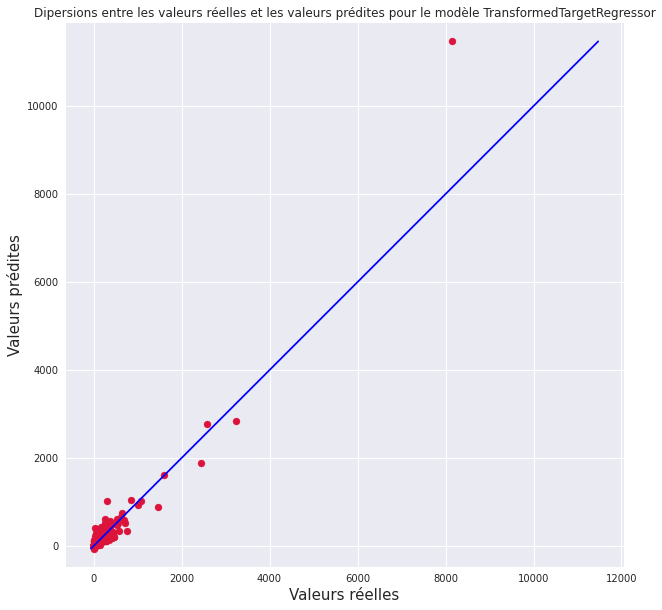

CPU times: user 4.04 s, sys: 0 ns, total: 4.04 s
Wall time: 4.04 s


In [224]:
%%time
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
gb =  GradientBoostingRegressor(learning_rate = 0.2, max_depth = 3, n_estimators = 1400, random_state=42)
transformer = Pipeline(steps=[
                              ('Robust', RobustScaler()),
                              ('MinMax', MinMaxScaler())
                             ]
                      )
model_co2 = TransformedTargetRegressor(regressor=gb, transformer=transformer)
model_co2.fit(X=X_co2_train_transformed_wo_estar, y=y_co2_train)
y_pred_test = model_co2.predict(X=X_co2_test_transformed_wo_estar)
r2 =  r2_score(y_true= y_co2_test, y_pred=y_pred_test)
print(f"Pour le modèle {type(model).__name__}")
print(f"R2 sur le jeu de test: {r2:.3f}")

plt.figure(figsize=(10,10))
plt.scatter(y_co2_test, y_pred_test, c='crimson')
p1 = max(max(y_pred_test), max(y_co2_test))
p2 = min(min(y_pred_test), min(y_co2_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Valeurs réelles', fontsize=15)
plt.ylabel('Valeurs prédites', fontsize=15)
plt.axis('equal')
plt.title(f"Dipersions entre les valeurs réelles et les valeurs prédites pour le modèle {type(model).__name__}")
plt.show()

Les deux modèle Gradient Boosting s'avère offrir de meilleur performance sur l'année 2016 et ce sur les deux variables à prédire.

## Enregistrement des modèles

In [228]:
import pickle
file_name_energy = "gradient_booting_energy.sav"
pickle.dump(model_energy, open(file_name_energy,"wb"))
file_name_co2 = "gradient_booting_co2.sav"
pickle.dump(model_co2, open(file_name_co2,"wb"))